# Implémentez un modèle de scoring

In this notebook, we will implement a model, which predicts the defaul risk for <a href="http://www.homecredit.net/about-us.aspx">Home Credit</a> loan applicants. In simple terms, we will calculate, for a given applicant, the default probability (in terms of percentage), and therefore predict wheter they will be able to repay the loan (on time) or not.<br>
Home Credit is a service dedicated to provided lines of credit to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit has been hosting a <a href="https://www.kaggle.com/competitions/home-credit-default-risk/overview/prizes">competition on Kaggle</a> for the best prediction models. Our <a href="https://www.kaggle.com/c/home-credit-default-risk/data">data</a> come from this competition.
Since our training set is labelized (i.e., it contains a column with the values <i>0</i> for applicants who did repaid their loans on time, and <i>1</i> for applicants who did not), we will be dealing with a <b>supervised learning classification</b> problem.

# <a id="tc"></a>Table of contents

0. [Preliminary steps](#0)
* 0.1. [Libraries and packages import](#0.1)
* 0.2. [Data import](#0.2)
1. [Quick tour](#1)
2. [Data cleaning](#2)
* 2.1. [First cleaning, preprocessing and merging](#2.1)
* 2.2. [Missing values](#2.2)
* 2.2.1. [Missing values imputation](#2.2.1)
* 2.4. [Outliers](#2.4)
* 2.5. [Negative values](#2.4.1)
* 2.4.2. [Values = infinite](#2.4.2)
* 2.4.3. [Age (*DAYS_BIRTH*)](#2.4.3)
* 2.4.4. [Other "days" features](#2.4.4)
* 2.4.5. [*REGION_RATING_CLIENT_W_CITY*](#2.4.5)
* 2.5. [Data storage after cleaning](#2.5)
3. [Data exploration](#3)
* 3.1. [Classes proportion in the dataset](#3.1)
* 3.2. [Variables correlation with the target](#3.2)
* 3.3. [Age of clients](#3.3)
* 3.4. [Exterior sources](#3.4)
* 3.5. [Feature engeneering](#3.5)
* 3.5.1. [Polynomial features](#3.5.1)
* 3.5.2. [Domain knowledge features](#3.5.2)
4. [Modelization](#4)
* 4.1. [Dummy Classifier (baseline)](#4.1)
* 4.2. [Logistic Regression](#4.2)
* 4.3. [(Balanced) Random Forest](#4.3)
* 4.4. [Light Gradient-Boosting Machine](#4.4)
* 4.5. [Further tests](#4.5)
* 4.6. [Models and datasets comparing](#4.6)
* 4.7. [Treshold optimization](#4.7)
* 4.8. [Pipeline](#4.8)
5. [Feature importance](#5)
* 5.1. [Global importance](#5.1)
* 5.2. [Local importance](#5.2)
6. [Data Drift](#6)
7. [Conclusions](#7)

# <a id="0"></a>0. Preliminary steps

In [1]:

#pip install devtools
#pip install imblearn
#pip install lightgbm
#pip install evidently
#pip install mlflow
#pip install shap

SyntaxError: invalid syntax (3212578632.py, line 5)

[back to table of contents](#tc)

## <a id="0.1"></a>0.1. Libraries and packages import

In [2]:
# Python version
from platform import python_version

# Operative system
import os, shutil

# Warnings 
import warnings

# Math
import numpy as np

# Data
import pandas as pd

# Regex
import re

# Casting
import ast

# CSV (comma separated values)
import csv

# Garbage collector
import gc

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures

# Imputation
from sklearn.impute import SimpleImputer

# Metrics
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix, make_scorer

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from lightgbm import LGBMClassifier

# Pipeline
from sklearn.pipeline import Pipeline

import mlflow
from mlflow.models.signature import infer_signature
import mlflow.sklearn

# URL handling modules
from urllib.parse import urlparse

# Object serializer
import pickle

# Dimensions reduction
from sklearn.decomposition import PCA

# Feature importance
import shap

# Evidently (data drift)
#from evidently import ColumnMapping
from evidently.report import Report
#from evidently.metrics.base_metric import generate_column_metrics
from evidently.metric_preset import DataDriftPreset #, TargetDriftPreset, DataQualityPreset, RegressionPreset
#from evidently.metrics import *
#from evidently.test_suite import TestSuite
#from evidently.tests.base_test import generate_column_tests
#from evidently.test_preset import DataStabilityTestPreset, NoTargetPerformanceTestPreset, RegressionTestPreset
#from evidently.tests import *


# Local functions
from local import functions as fc

Local functions: version 1.2.1 (August 10th, 2023)


In [3]:
print(python_version())

3.9.12


In [4]:
# Warnings suppression
warnings.filterwarnings('ignore')
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Script execution start time
script_start_time = fc.set_start()

In [6]:
# Paths definition
data_path = './data/'
source_data_path = data_path + 'source/'
cleaned_data_path = data_path + 'cleaned/'
calc_path = './calc/' # Stored GridSearchCV results and predictions
model_path = './models'

[back to table of contents](#tc)

## <a id="0.2"></a>0.2. Data import
Source of data: https://www.kaggle.com/c/home-credit-default-risk/data.

In [14]:
# Datasets import
def create_df(filename, path=source_data_path):
    path = path + filename
    with open(path, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        header = True
        i = 0
        for row in reader:
            if(header):
                df = pd.DataFrame(columns=row)
                header = False
            else:
                df.loc[-1] = row
                df.index = df.index + 1
            i += 1
        idx = np.arange(i-1)
        df.index = idx
        df = df.iloc[:,1:]
    csvfile.close()
    return df

In [15]:
# Datasets load
skip = [5]
dir_list = os.listdir(source_data_path)
df_name_list = []
n_files = len(dir_list)
print(f"{n_files} datasets have been loaded:\n")
for n in range(0,n_files):
    dyn_var_name = dir_list[n]
    dyn_var_name = 'df_' + dyn_var_name[:-4]
    if(n not in skip):
        globals()[dyn_var_name] = pd.read_csv(source_data_path + dir_list[n])
    else:
        globals()[dyn_var_name] = create_df(dir_list[n], source_data_path)
    shape = globals()[dyn_var_name].shape
    df_name_list.append(dyn_var_name)
    print(f" {n+1}) {dyn_var_name} {shape}")

10 datasets have been loaded:

 1) df_application_test (48744, 121)
 2) df_application_train (307511, 122)
 3) df_bureau (1716428, 17)
 4) df_bureau_balance (27299925, 3)
 5) df_credit_card_balance (3840312, 23)
 6) df_HomeCredit_columns_description (219, 4)
 7) df_installments_payments (13605401, 8)
 8) df_POS_CASH_balance (10001358, 8)
 9) df_previous_application (1670214, 37)
 10) df_sample_submission (48744, 2)


[back to table of contents](#tc)

# <a id="1"></a>1. Quick tour

In [16]:
df_application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [19]:
df_bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [20]:
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [21]:
df_HomeCredit_columns_description.head()

,Table,Row,Description,Special
0,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,
1,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,
2,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,
3,application_{train|test}.csv,CODE_GENDER,Gender of the client,
4,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,


In [22]:
df_installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [23]:
df_POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [24]:
df_previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_sample_submission.head()

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


In [26]:
# Setting target label
target = 'TARGET'

Datasets have been correctly loaded. The following schema represents how datasets have to be joint.

<img src="https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png">

As shown in our quick tour (see above), our main dataset (<i>application_{train|test}.csv</i>) is split into two subdatasets: a training one (<i>application_train</i>), and a testing one (<i>application_test</i>). However, since the testing set is conceived for the submission in the <a href="https://www.kaggle.com/competitions/home-credit-default-risk/overview/prizes">Kaggle competition</a>, we don't its labels.
<br>Therefore, we will use part of the training set as validation set, in order to test and refine our models.
Then, we will use the testing set as new data for (a) the data drift analysis and (b) the implementation of our API and dashboard.

In [27]:
# Visualize the description of a given column
def get_col_desc(col, table='application_{train|test}.csv', ret=False):
    df_temp = df_HomeCredit_columns_description.loc[df_HomeCredit_columns_description['Row'] == col]
    if(df_temp.shape[0]<1):
        desc = f"{col}: not in the original dataset(s)."
    else:
        if(table!=None):
            df_temp = df_temp.loc[df_temp['Table'] == table]
        desc = df_temp['Description'].values[0]
        desc = f"{col} [{table}]: {desc}"
    if(ret):
        return desc
    else:
        print(desc)

[back to table of contents](#tc)
# <a id="2"></a>2. Data cleaning

For the following cleaning and analysis operations, we will get inspiration from the following <a href="https://www.kaggle.com/">Kaggle</a> kernels:

- https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook: this notebook, "intended for those who are new to machine learning competitions or want a gentle introduction to the problem" (quote), just considers the main dataset (<i>application_{train|test}.csv</i>); it is very clear and detailed in the explanations, and it contains simple but interesting analysis (with good and fancy graphs) and feature engeneering steps.
- https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script: this script uses all datasets, and integrates a good data cleaning, which we will borrow.

Forthermore, for the modelization, the kernels uses different models.<br>
We will somewhere modify and integrate the abovementioned codes, in order to refine and adapt them to our objectives.

In [28]:
'''
# Get a copy of main training and testing sets
df_train = df_application_train.copy()
df_test  = df_application_test.copy()
'''

'\n# Get a copy of main training and testing sets\ndf_train = df_application_train.copy()\ndf_test  = df_application_test.copy()\n'

[back to table of contents](#tc)
## <a id="2.1"></a>2.1. First cleaning, preprocessing and merging

At first, we will practice the preprocessing operations from <a href="https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script">Aguiar's script</a>. But first, we will convert to positive the values of columns whose values are expressed in terms of (number of) <i>days</i> (from the "zero" time, therefore a negative quantity), in order to get more understandable data.

In [29]:
# Convert day numbers to positive
for df_name in df_name_list:
    cols = globals()[df_name].columns
    for col in cols:
        if('DAYS' in col):
            globals()[df_name][col] = abs(globals()[df_name][col])

In [30]:
# Preprocess functions
# Code (with some modification) from Aguiar's LightGBM with Simple Features

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype=='object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(n_rows=None, nan_as_category=False):
    # Read data and merge
    df = df_application_train.iloc[:n_rows,:]
    test_df = df_application_test.iloc[:n_rows,:]
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # "DAYS" variable conversion to positive
    days_cols = ['DAYS_BIRTH', 
                 'DAYS_EMPLOYED', 
                 'DAYS_REGISTRATION', 
                 'DAYS_ID_PUBLISH',
                 'DAYS_LAST_PHONE_CHANGE']
    for col in days_cols:
        df[col] = abs(df[col])
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(n_rows=None, nan_as_category=True):
    bureau = df_bureau.iloc[:n_rows,:]
    bb = df_bureau_balance.iloc[:n_rows,:]
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(n_rows=None, nan_as_category=True):
    prev = df_previous_application.iloc[:n_rows,:]
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(n_rows=None, nan_as_category=True):
    pos = df_POS_CASH_balance.iloc[:n_rows,:]
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(n_rows=None, nan_as_category=True):
    ins = df_installments_payments.iloc[:n_rows,:]
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(n_rows=None, nan_as_category=True):
    cc = df_credit_card_balance.iloc[:n_rows,:]
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [31]:
# Merge function (integrates preprocess)
# Code (with some modification) from Aguiar's LightGBM with Simple Features

def merge_and_preprocess(debug=False):

    if(debug):
        n_rows = 1000
    else: n_rows = None

    df = application_train_test(n_rows)

    with fc.timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(n_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with fc.timer("Process previous_applications"):
        prev = previous_applications(n_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with fc.timer("Process POS-CASH balance"):
        pos = pos_cash(n_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with fc.timer("Process installments payments"):
        ins = installments_payments(n_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with fc.timer("Process credit card balance"):
        cc = credit_card_balance(n_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    
    df.drop(columns='index', inplace=True)
    
    return df

In [32]:
# Getting a preprocessed and merged dataset
df = merge_and_preprocess()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 44s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 57s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 26s
Installments payments df shape: (339587, 26)
Process installments payments - done in 66s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 56s


In [33]:
# Dataframe shape after merging
fc.print_shape(df)

The dataframe contains 356251 rows and 797 columns.


Once preprocessed and merged our datasets, let's practice further cleaning checks and operations.

[back to table of contents](#tc)
## <a id="2.2"></a>2.2. Missing values

In [34]:
# Calculate missing values, in terms of absolute values and percentage
def calc_miss(df, print_res=True, ret=True, include_0_mv=False):
        
    df_temp   = df.isna().sum()
    n_rows    = df.shape[0]
    n_col     = df.shape[1]
    df_n_null = df.isna().sum().sum()
    cols = ['column', 'n_miss', '%_miss']
    df_null = pd.DataFrame(columns=cols)
    df_null['column'] = df_temp.index
    df_null['n_miss'] = df_temp.values
    df_null['%_miss'] = round(df_null['n_miss'] / n_rows, 1) * 100
    df_null = df_null.loc[df_null['n_miss'] > 0].sort_values('n_miss', ascending=False)
    n_col_miss = df_null.shape[0]
    
    if(include_0_mv==False):
        df_null = df_null.loc[df_null['%_miss'] > 0]
        
    if(print_res):
        res  = f"The dataframe contains {df_n_null} missing values. "
        res += f"{n_col_miss} of {n_col} columns contain missing values."
        print(res)
    
    if(ret):
        return df_null

In [35]:
# Missing values in the training set
df_miss = calc_miss(df)
df_miss

The dataframe contains 72099981 missing values. 617 of 797 columns contain missing values.


,column,n_miss,%_miss
605,REFUSED_RATE_DOWN_PAYMENT_MAX,303648,90.0
604,REFUSED_RATE_DOWN_PAYMENT_MIN,303648,90.0
606,REFUSED_RATE_DOWN_PAYMENT_MEAN,303648,90.0
595,REFUSED_AMT_DOWN_PAYMENT_MIN,303648,90.0
596,REFUSED_AMT_DOWN_PAYMENT_MAX,303648,90.0
...,...,...,...
379,PREV_AMT_GOODS_PRICE_MIN,18462,10.0
363,PREV_AMT_ANNUITY_MIN,17878,10.0
364,PREV_AMT_ANNUITY_MAX,17878,10.0
365,PREV_AMT_ANNUITY_MEAN,17878,10.0


In [36]:
# plot missing values percentage
def plot_miss(df, treshold=0.3, height=120):
    
    plt.figure(figsize=(12,height))
    sns.barplot(data=df.sort_values('%_miss', ascending=False), x='%_miss', y='column', palette='ch:s=.25,rot=-.25')
    plt.title(f"Missing values (%) for each column")
    plt.xlabel("Missing values (%)")
    plt.ylabel("Column")
    plt.axvline(x=100-treshold*100, linewidth=2, color = 'r')
    plt.show()

As we can see in the above dataframe and (better) in the below barplot, our dataset has a lot of missing values.<br>
We establish a treshold of <b>50%</b> to keep just the best columns in terms of filling rate.

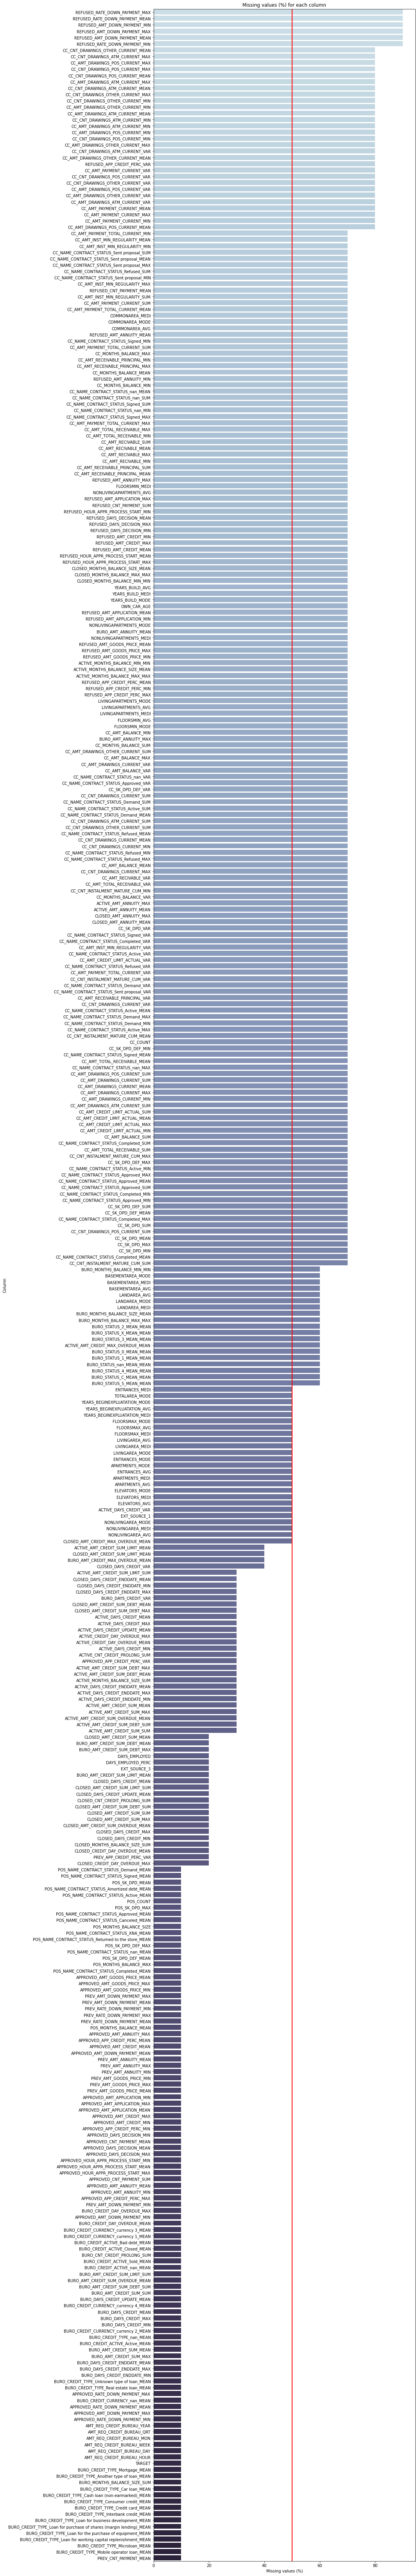

In [37]:
treshold = 0.5

# Plot missing values in the training set
plot_miss(df_miss, treshold)

In [38]:
cols_to_drop = df_miss.loc[df_miss['%_miss'] > treshold * 100, 'column']
df = df.drop(columns=cols_to_drop)
fc.print_shape(df)

The dataframe contains 356251 rows and 579 columns.


[back to table of contents](#tc)
### <a id="2.2.1"></a>2.2.1. Missing values imputation

For the remaining columns, we will impute the missing values in the following ways:
- for the target, which is missing in the rows coming from <i>application_test.csv</i>, we will assign the value <b><i>2</b></i>, as test set marker;
- for the quantitative variables (but the aggregation ones), missing values will be replaced by the median;
- for the aggregation variables, missing values will be replaced by zero;
- for the qualitatives variables, missing values will be replaced by the most frequent one.

In [39]:
# Target imputation (testing set: target = 2)
df[target] = df[target].fillna(2)
df[target] = df[target].astype(int)

In our encoded dataset, quantitative and qualitative variables can be distinguished thanks to the value type: float for the quantitative variables, integer for the qualitative ones.

In [40]:
df.dtypes.value_counts()

float64    403
uint8      133
int64       42
int32        1
dtype: int64

In [41]:
# Getting name list of quantitative and qualitative variables
quanti_cols = df.select_dtypes(['float64']).columns
quali_cols = df.select_dtypes(df.dtypes.value_counts().iloc[1:].index.tolist()).columns

In [42]:
# Aggregation columns imputing
cols_agg = df.columns[df.columns.str.contains('_MIN|_MAX|_MEAN|_VAR|_SUM|_SIZE')]
df[cols_agg] = df[cols_agg].fillna(0.0)

In [43]:
# Impute missing values of a given dataset
def impute(df, cols, var_type):
    
    if(var_type=='qualitative'):
        strat = 'most_frequent'
    else:
        strat = 'median'
        
    cols = df[cols].isna().sum().loc[df[cols].isna().sum() > 0].index.tolist()
    n_cols = len(cols)
    if(n_cols>0):
        imputer = SimpleImputer(strategy=strat)
        imputed_values = imputer.fit_transform(df[cols])
        df[cols] = pd.DataFrame(imputed_values)
        res = f"Empty values of {n_cols} columns ({var_type} variables) have been imputed (strategy: {strat})."
    else:
        res = f"There were no empty values to impute ({var_type} variables)."
        
    print(res)
    return df

In [44]:
# Missing values imputation
df = impute(df, quanti_cols, var_type='quantitative')
df = impute(df, quali_cols, var_type='qualitative')

calc_miss(df, print_res=True, ret=False)

Empty values of 47 columns (quantitative variables) have been imputed (strategy: median).
There were no empty values to impute (qualitative variables).
The dataframe contains 188 missing values. 47 of 579 columns contain missing values.


[back to table of contents](#tc)
## <a id="2.3"></a>2.3. Duplicates

In [45]:
def check_duplicates(df):
    n_duplicates = df.duplicated().sum()
    print(f"In the dataset set there are {n_duplicates} duplicates.")

In [46]:
check_duplicates(df)

In the dataset set there are 0 duplicates.


[back to table of contents](#tc)
## <a id="2.4"></a>2.4. Outliers

In [47]:
df.describe()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
count,356251.000000,356251.000000,356251.000000,356251.000000,356251.000000,356251.000000,3.562510e+05,3.562510e+05,356247.000000,3.562470e+05,...,3.562510e+05,3.562510e+05,3.562510e+05,3.562510e+05,3.562510e+05,3.562510e+05,356251.000000,356251.000000,356251.000000,356247.000000
mean,278128.870078,0.343334,0.660001,0.339699,0.306764,0.414312,1.701159e+05,5.877695e+05,27425.411831,5.279580e+05,...,1.774482e+04,6.511687e+05,5.035477e+03,1.334885e+05,1.811424e+04,6.581827e+05,1525.928525,878.928919,40133.301650,39.359691
std,102842.068890,0.706475,0.473709,0.473608,0.461151,0.720376,2.235080e+05,3.986253e+05,14732.201739,3.659299e+05,...,2.324457e+04,8.840715e+05,1.419923e+04,2.455316e+05,2.495877e+04,9.204762e+05,953.783015,614.715238,56224.601556,40.207569
min,100001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.000000
25%,189065.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16731.000000,2.340000e+05,...,7.247589e+03,1.183687e+05,2.403000e+01,1.271560e+04,6.950888e+03,1.151533e+05,647.000000,385.333333,5497.000000,12.000000
50%,278129.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.530000e+05,5.002110e+05,25078.500000,4.500000e+05,...,1.216491e+04,3.061444e+05,1.738440e+03,3.315767e+04,1.183227e+04,2.974840e+05,1472.000000,766.750000,19445.000000,25.000000
75%,367192.500000,0.000000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,7.975575e+05,34960.500000,6.750000e+05,...,2.095620e+04,8.155875e+05,6.846030e+03,1.260000e+05,2.092264e+04,8.066012e+05,2461.000000,1284.127016,47547.000000,49.000000
max,456255.000000,2.000000,1.000000,1.000000,1.000000,20.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,...,2.504590e+06,3.247978e+07,2.504590e+06,3.771488e+06,2.504590e+06,3.268928e+07,4921.000000,3071.000000,602499.000000,372.000000


[back to table of contents](#tc)
### <a id="2.4.1"></a>2.4.1. Negative values

In [48]:
# Check columns with negative values in a given dataframe
def check_neg(df, print_res=True, ret=True):
    df_neg = df.select_dtypes(include=np.number)
    neg_cols = []
    for col in df_neg.columns:
        if(df_neg[col].min() < 0):
            neg_cols.append(col)
    df_neg = df_neg[neg_cols]
    n_neg_cols = len(neg_cols)
    if(print_res):
        sep = ', '
        res  = f"In the dataset set there are {n_neg_cols} columns with negative values: "
        res += sep.join(neg_cols) + '.'
        print(res)
    if(ret):
        return df_neg

In [49]:
# Check negative values in training set
df_neg = check_neg(df)

In the dataset set there are 29 columns with negative values: REGION_RATING_CLIENT_W_CITY, BURO_AMT_CREDIT_SUM_DEBT_MAX, BURO_AMT_CREDIT_SUM_DEBT_MEAN, BURO_AMT_CREDIT_SUM_DEBT_SUM, BURO_AMT_CREDIT_SUM_LIMIT_MEAN, BURO_AMT_CREDIT_SUM_LIMIT_SUM, ACTIVE_AMT_CREDIT_SUM_DEBT_MAX, ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN, ACTIVE_AMT_CREDIT_SUM_DEBT_SUM, ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN, ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM, CLOSED_AMT_CREDIT_SUM_DEBT_MAX, CLOSED_AMT_CREDIT_SUM_DEBT_MEAN, CLOSED_AMT_CREDIT_SUM_DEBT_SUM, CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN, CLOSED_AMT_CREDIT_SUM_LIMIT_SUM, PREV_AMT_DOWN_PAYMENT_MIN, PREV_AMT_DOWN_PAYMENT_MEAN, PREV_RATE_DOWN_PAYMENT_MIN, PREV_RATE_DOWN_PAYMENT_MEAN, APPROVED_AMT_DOWN_PAYMENT_MIN, APPROVED_AMT_DOWN_PAYMENT_MEAN, APPROVED_RATE_DOWN_PAYMENT_MIN, APPROVED_RATE_DOWN_PAYMENT_MEAN, POS_MONTHS_BALANCE_MAX, POS_MONTHS_BALANCE_MEAN, INSTAL_PAYMENT_DIFF_MAX, INSTAL_PAYMENT_DIFF_MEAN, INSTAL_PAYMENT_DIFF_SUM.


As we can see, there are some columns, which contain negative values. Let's have a look to them, in order to check wheter such variables are supposed to have negative values or not. To do that, as first step, we will read the column descriptions. 

In [50]:
# Description of columns with negative values (training set)
for col in df_neg.columns:
    get_col_desc(col, ret=False)

REGION_RATING_CLIENT_W_CITY [application_{train|test}.csv]: Our rating of the region where client lives with taking city into account (1,2,3)
BURO_AMT_CREDIT_SUM_DEBT_MAX: not in the original dataset(s).
BURO_AMT_CREDIT_SUM_DEBT_MEAN: not in the original dataset(s).
BURO_AMT_CREDIT_SUM_DEBT_SUM: not in the original dataset(s).
BURO_AMT_CREDIT_SUM_LIMIT_MEAN: not in the original dataset(s).
BURO_AMT_CREDIT_SUM_LIMIT_SUM: not in the original dataset(s).
ACTIVE_AMT_CREDIT_SUM_DEBT_MAX: not in the original dataset(s).
ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN: not in the original dataset(s).
ACTIVE_AMT_CREDIT_SUM_DEBT_SUM: not in the original dataset(s).
ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN: not in the original dataset(s).
ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM: not in the original dataset(s).
CLOSED_AMT_CREDIT_SUM_DEBT_MAX: not in the original dataset(s).
CLOSED_AMT_CREDIT_SUM_DEBT_MEAN: not in the original dataset(s).
CLOSED_AMT_CREDIT_SUM_DEBT_SUM: not in the original dataset(s).
CLOSED_AMT_CREDIT_SUM_LIMIT

The only column with negative values, which was in the original files, is <i>REGION_RATING_CLIENT_W_CITY</i>, whose negative values have to be considered as errors (see the column description).<br>
Let's see in detail these values.

In [51]:
df.loc[df['REGION_RATING_CLIENT_W_CITY'] < 0, 'REGION_RATING_CLIENT_W_CITY']

324688   -1
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64

As clearly explained in the column description, <i>REGION_RATING_CLIENT_W_CITY</i> is supposed to have, as value, 1, 2 or 3. Therefore, we will just take the absolute value of this outlier.

In [52]:
df.loc[df['REGION_RATING_CLIENT_W_CITY'] < 0, 
          'REGION_RATING_CLIENT_W_CITY'] = abs(df['REGION_RATING_CLIENT_W_CITY'])

[back to table of contents](#tc)
### <a id="2.4.2"></a>2.4.2. Values = infinite

We will check, wheter the dataframe contain any value = (-) infinite (which is, of course, an outlier). Such rows will be deleted.

In [53]:
# Create a dataframe with the rows containing columns with values = (-)infinite
col = 'n_inf_values'
df_inf = pd.DataFrame(df.isin([np.inf, -np.inf]).sum(), columns=[col])
df_inf = df_inf.loc[df_inf[col] != 0]
df_inf

,n_inf_values
PREV_APP_CREDIT_PERC_MAX,1
INSTAL_PAYMENT_PERC_MAX,19


In [54]:
# Deleting rows with values = (-)infinite
n_inf_values = df_inf[col].sum()
cols = df_inf.index

for col in cols:
    df = df.loc[(df[col] != np.inf) & (df[col] != -np.inf)]

res = f"{n_inf_values} rows containing infinite values have been deleted (columns: {cols[0]})."
print(res)

20 rows containing infinite values have been deleted (columns: PREV_APP_CREDIT_PERC_MAX).


[back to table of contents](#tc)
### <a id="2.4.3"></a>2.4.3. Age (*DAYS_BIRTH*)

We will check the age range: clients can't be neither minors nor older than a human being is supposed to be.

In [55]:
# Dispaly age of oldest and youngest clients in a dataset
def check_age(df, train=True):
    year = 365
    age_max = df['DAYS_BIRTH'].min() / year
    age_min = df['DAYS_BIRTH'].max() / year
    age_max = round(age_max)
    age_min = round(age_min)
    print(f"The oldest client in the dataset is {age_max} years old.")
    print(f"The youngest client in the dataset is {age_min} years old.")

In [56]:
# Display ages (training and testing set)
check_age(df)

The oldest client in the dataset is 20 years old.
The youngest client in the dataset is 69 years old.


20-70 years old seems to be a reasonable age range.

[back to table of contents](#tc)
### <a id="2.4.4"></a>2.4.4. Other "days" features

We can assume that whatever date concerning a given applicant (beginning of current employment, phone change, etc.) can't be prior to their birth, otherwise it has to be considered an as a wrong value (outlier).

In [57]:
# Check date anomalies 
def check_days_feat(df, print_res=True, ret=False):
    cols = [col for col in df.columns.tolist() if col[0:4] == 'DAYS']
    cols.remove('DAYS_BIRTH')
    date_anomalies = dict()
    for col in cols:
            
        df['date_anomaly'] = False
        df.loc[df[col] > df['DAYS_BIRTH'], 'date_anomaly'] = True
        n_anomalies = df.loc[df['date_anomaly'] == True].shape[0]
        date_anomalies[col] = n_anomalies
    
    date_anomalies = {k: v for k, v in date_anomalies.items() if v > 0}
    
    df.drop(columns='date_anomaly', inplace=True)
    
    if(print_res):
        print(f"Number of anomalies for each variable: {date_anomalies}")
            
    if(ret):
        return date_anomalies

In [58]:
# Display dates anomalies (training and testing set)
check_days_feat(df)

Number of anomalies for each variable: {'DAYS_EMPLOYED': 1107, 'DAYS_REGISTRATION': 1}


Let's go deeper in these anomalies.

In [59]:
df.loc[df['DAYS_EMPLOYED'] > df['DAYS_BIRTH'], ['DAYS_EMPLOYED', 'DAYS_BIRTH']]

,DAYS_EMPLOYED,DAYS_BIRTH
35823,12536.0,11173
36854,13381.0,11645
37010,12260.0,11225
37274,14102.0,10668
37776,12111.0,9677
...,...,...
354409,13645.0,12638
354504,17124.0,15395
354635,10602.0,8847
355147,10150.0,8907


Being impossible to recover the right values, they will be set <i>DAYS_EMPLOYED</i> wrong values as equal to <i>DAYS_BIRTH</i> corresponding ones.<br>
Let's consider, now, <i>DAYS_REGISTRATION</i>.

In [60]:
df = df.loc[df['DAYS_EMPLOYED'] < df['DAYS_BIRTH'], :]

It seems we have just one anomaly. Let's have a look to it in detail.

In [61]:
df.loc[df['DAYS_REGISTRATION'] > df['DAYS_BIRTH'], ['DAYS_REGISTRATION', 'DAYS_BIRTH']]

,DAYS_REGISTRATION,DAYS_BIRTH
266366,10116.041667,10116


As shown, it's clearly an anomaly, since the column value (expressed in days) is supposed to be an integer. As we can see, the integer part of the value equals the corresponding value of <i>DAYS_BIRTH column</i>, therefore we will set it as <i>DAYS_REGISTRATION</i> value (in several other rows, the values of both columns are the same).

In [62]:
df.loc[df['DAYS_REGISTRATION'] > df['DAYS_BIRTH'], 'DAYS_REGISTRATION'] = df['DAYS_BIRTH']

[back to table of contents](#tc)
### <a id="2.4.5"></a>2.4.5. *REGION_RATING_CLIENT_W_CITY*

As said before, <i>REGION_RATING_CLIENT_W_CITY</i> is supposed to have, as value, 1, 2 or 3. We have already corrected a wrong value (negative). Let's serch for others.

In [63]:
df.loc[(df['REGION_RATING_CLIENT_W_CITY'] != 1) & 
       (df['REGION_RATING_CLIENT_W_CITY'] != 2) &
       (df['REGION_RATING_CLIENT_W_CITY'] != 3), 
       'REGION_RATING_CLIENT_W_CITY']

Series([], Name: REGION_RATING_CLIENT_W_CITY, dtype: int64)

[back to table of contents](#tc)
## <a id="2.5"></a>2.5. Data storage after cleaning

In [64]:
# Data storage in .csv file
def store_data(df,
               df_type, 
               path=cleaned_data_path,
               ext='.csv',
               sep='\t', 
               index=None,
               print_res=True):
    
    filename = path + 'data_' + df_type + ext
    df.to_csv(filename, sep=sep, index=index)
    if(print_res):
        res = f"Data storage ({filename}): ok."
        print(res)

In [65]:
# Split merged dataset into training and testing set (uses a test marker as value for the target column)
def split_train_test(df, tar=target, test_marker=2, drop_tar=True):
    df_1 = df.loc[df[tar] != test_marker, :] # Training test
    df_2 = df.loc[df[tar] == test_marker, :] # Testing set
    if(drop_tar):
        df_2.drop(columns=tar, inplace=True)
    return df_1, df_2

In [66]:
# Merge training and testing set in a whole dataset.
def merge_train_test(df_train, df_test, tar=target, test_marker=2):
    df_1 = df_train.copy()
    df_2 = df_test.copy()
    if(df_1.columns[-1] != tar):
        target_values = df_1.pop(target)
        df_1.insert(df_1.shape[1], tar, target_values)
    df_2[tar] = test_marker
    df_merge = pd.concat([df_1, df_2])
    return df_merge

In [67]:
df_train_enc, df_test_enc = split_train_test(df)

In [68]:
# Export data to files (.csv)
store_data(df_train_enc, 'train_enc')
store_data(df_test_enc, 'test_enc')

Data storage (./data/cleaned/data_train_enc.csv): ok.
Data storage (./data/cleaned/data_test_enc.csv): ok.


[back to table of contents](#tc)
# <a id="3"></a>3. Data exploration

Since most of the following analysis steps are related to the target, we will consider only the training set.

## <a id="3.1"></a>3.1. Classes proportion in the dataset
The following pie chart shows that we have to deal with an unbalanced dataset. Only 8% of our training set's rows refer to clients, who dit not repay their loans on time. In other words, we are facing a rare-event detection problem.<br>
When we will train our models (see below, [§ 4](#4)), we will have to deal with this imbalance.

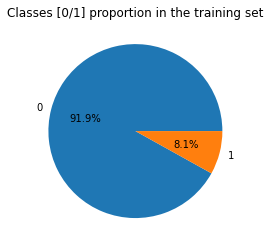

In [69]:
# Proportions of the two classesplt.figure(figsize=(8,8))
df_application_train[target].value_counts()
plt.pie(labels=df_application_train[target].value_counts().index, 
        x=df_application_train[target].value_counts().values, 
        autopct='%1.1f%%')

plt.title("Classes [0/1] proportion in the training set")
plt.show()

[back to table of contents](#tc)
## <a id="3.2"></a>3.2. Variables correlation with the target

In the following chart, we will show the main correlations and anticorrelations between the dataset variables and the target, according to both Pearson's and Spearman's coeeficients.

In [70]:
# Statistics
from scipy import stats

# Coefficients list
coef_pearson=[]
coef_spearman=[]

# Simplified labels list
label_pearson=[]
label_spearman=[]

# Colors list
colorp=[]
colors=[]
blu="#9fb4ff"
red="#ffae9f"

# Treshold (under this value, the correlation is not shown)
treshold = 0.05

cols = df_train_enc.columns.tolist()
cols.remove(target)

# Getting information
for col in cols:
    cp=stats.pearsonr(df_train_enc[target].values, df_train_enc[col])[0]
    cs=stats.spearmanr(df_train_enc[target].values, df_train_enc[col])[0]

    # For Pearson correlation coefficient
    if (abs(cp) >= treshold):
        coef_pearson.append(cp)
        label_pearson.append(col)
        if (cp > 0):
            colorp.append(blu)
        else:
            colorp.append(red)
    
    # For Spearman correlation coefficient                       
    if (abs(cs) >= treshold):
        coef_spearman.append(cs)
        label_spearman.append(col)
        if (cs > 0):
            colors.append(blu)
        else:
            colors.append(red)

In [71]:
# Variables correlation with target barplot
def plot_corr(subpl, coef_type, coef_list, label_list):
    
    if(subpl==1):
        fig=plt.figure(1,figsize=[20,5])
        fig.patch.set_facecolor('#E0E0E0')
        fig.patch.set_alpha(0.7)
        plt.suptitle("Main (anti)correlation of variables with target",size=16)
    
    x_len = np.arange(len(label_list)) + 1
    y_len = len(label_list) + 0.5
    plt.subplot(1, 2, subpl)
    plt.title(f"{coef_type} correlation coefficient")
    plt.bar(x_len, coef_list, color=colorp, edgecolor='black')
    plt.xticks(x_len, label_list, rotation=90)
    plt.hlines(0, 0.5, y_len, color='black')
    plt.ylabel("coefficient value")
    plt.ylim(-1, 1)
    plt.grid(True)

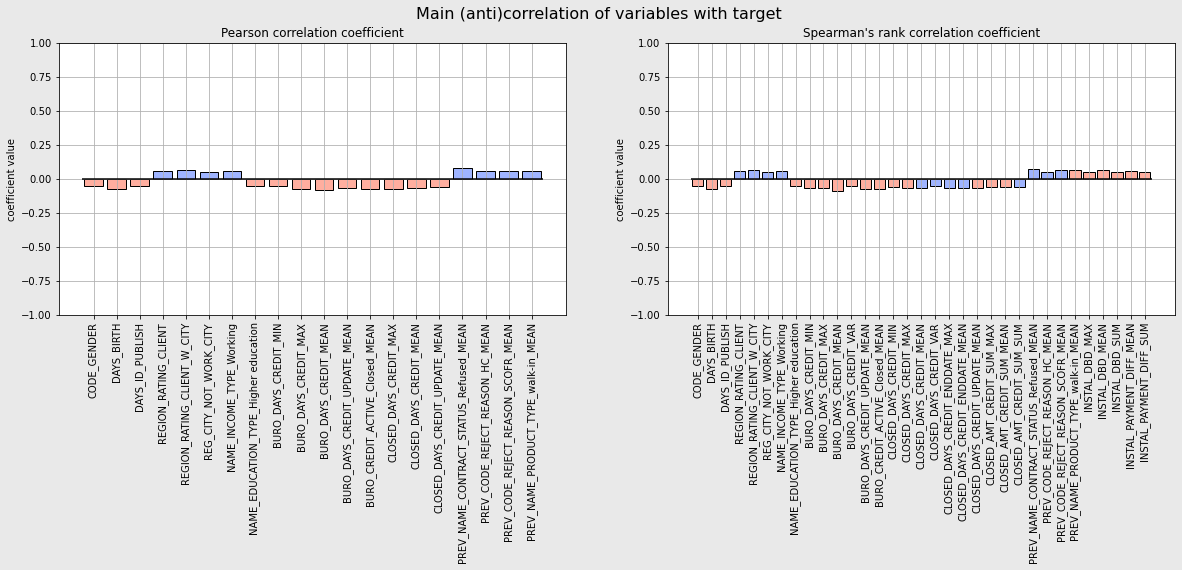

In [72]:
# 1st barplot: Pearson correlation coefficients
plot_corr(1, "Pearson", coef_pearson, label_pearson)

# 2nd barplot: Spearman correlation coefficients
plot_corr(2, "Spearman's rank", coef_spearman, label_spearman)

Let's keep in mind these results, because they can be related to the the (<b>local</b> and <b>global</b>) <b>feature importance</b>, which will measured later, once the final model defined and set.

[back to table of contents](#tc)
## <a id="3.3"></a>3.3. Age of clients

First, we will plot the client age distribution.

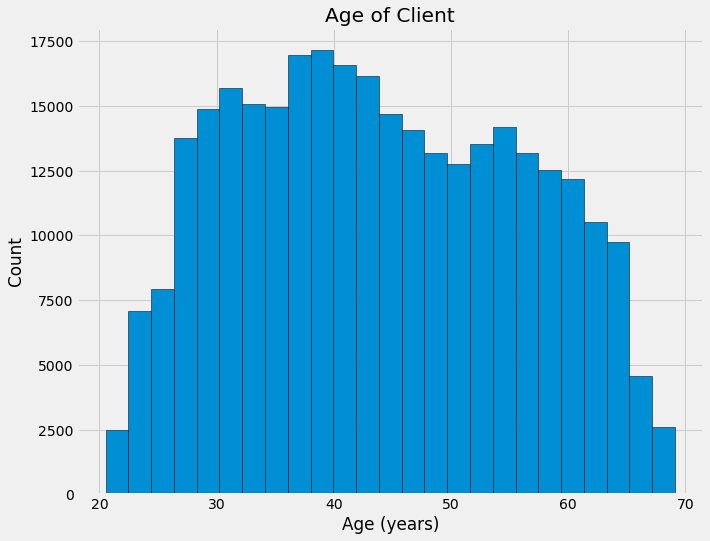

In [73]:
# Plot the distribution of ages in years
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,8))
plt.hist(df_train_enc['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

The plot show us a quite regular distribution of ages, with the highest values around 40 years.<br>
Now, let's have a look at the relation between age and target.

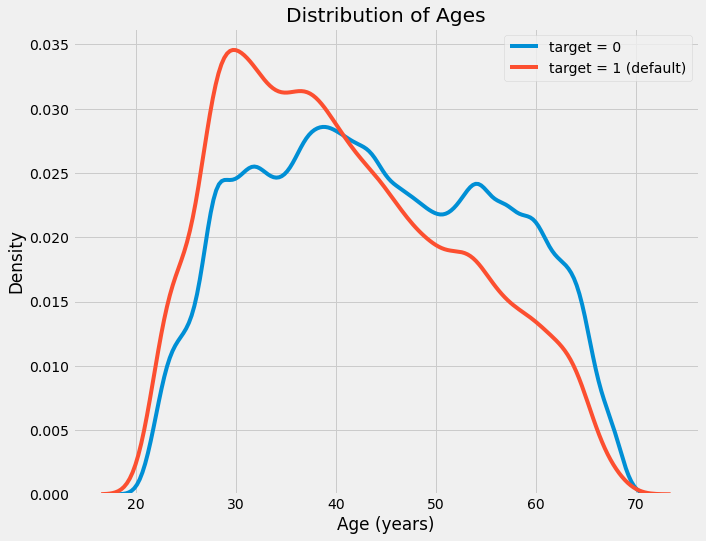

In [74]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(df_train_enc.loc[df_train_enc[target] == 0, 'DAYS_BIRTH'] / 365, label='target = 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df_train_enc.loc[df_train_enc[target] == 1, 'DAYS_BIRTH'] / 365, label='target = 1 (default)')

# Labeling of plot
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')
plt.legend()
plt.show()

It seems the age is somehow related to the target values. Let's search for a trend.

In [75]:
# Age information into a separate dataframe
df_age = df_train_enc[[target, 'DAYS_BIRTH']]
df_age['YEARS_BIRTH'] = df_age['DAYS_BIRTH'] / 365

# Bin the age data
df_age['YEARS_BINNED'] = pd.cut(df_age['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
df_age.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [76]:
# Group by the bin and calculate averages
df_age_groups  = df_age.groupby('YEARS_BINNED').mean()
df_age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.122887,8533.616620,23.379772
"(25.0, 30.0]",0.111313,10156.797789,27.826843
"(30.0, 35.0]",0.102797,11855.465849,32.480728
"(35.0, 40.0]",0.089431,13708.214232,37.556751
"(40.0, 45.0]",0.078501,15497.731106,42.459537
"(45.0, 50.0]",0.074184,17323.936150,47.462839
"(50.0, 55.0]",0.066976,19196.528307,52.593228
"(55.0, 60.0]",0.055317,20984.301135,57.491236
"(60.0, 65.0]",0.052745,22780.544409,62.412450


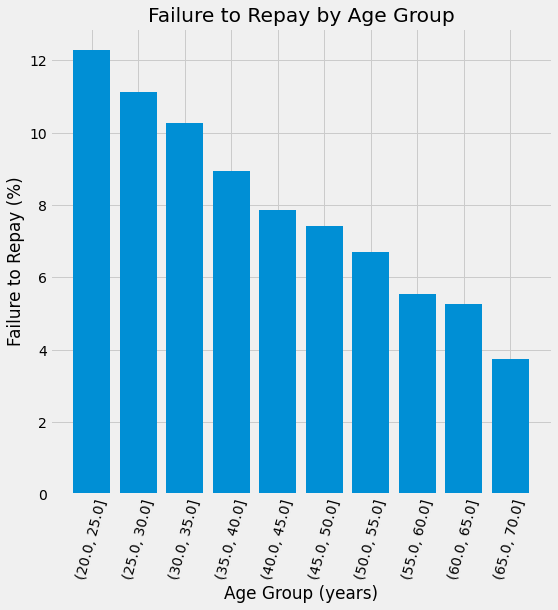

In [77]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(df_age_groups.index.astype(str), 100 * df_age_groups[target])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

The plot show us that older clients are more reliable of younger ones.

[back to table of contents](#tc)
## <a id="3.4"></a>3.4. Exterior sources

In the following table and heatmap, we will outline the correlations between EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 and the target. "According to the documentation, these features represent a "normalized score from external data source" (quote from <a href="https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook">Will Koehrsen's notebook</a>). Therefore, they could be quite interesting for our work, since they are the results of prior data manipulations.<br>
Let's take a look at these variables.

In [78]:
# Extract the EXT_SOURCE variables and show correlations
df_ext_data = df_train_enc[[target, 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corr = df_ext_data.corr()
for i in range(ext_data_corr.shape[0]):
    ext_data_corr.iloc[i,i] = np.nan
ext_data_corr

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,NaN,-0.012549,-0.022840,-0.017949,-0.078021
EXT_SOURCE_1,-0.012549,NaN,0.135020,0.109394,0.043919
EXT_SOURCE_2,-0.022840,0.135020,NaN,0.094141,0.013200
EXT_SOURCE_3,-0.017949,0.109394,0.094141,NaN,0.023706
DAYS_BIRTH,-0.078021,0.043919,0.013200,0.023706,NaN


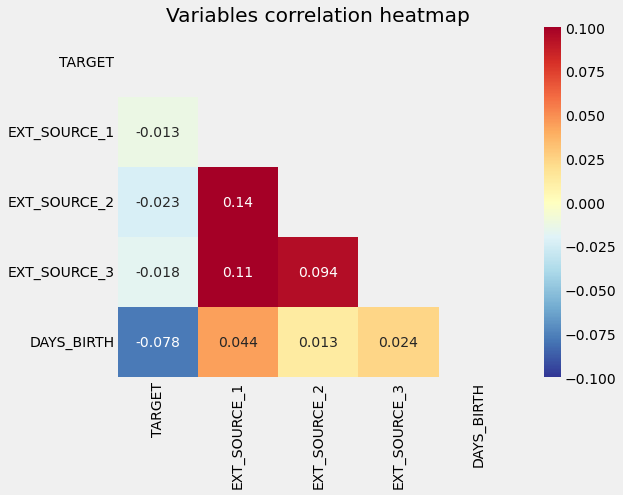

In [79]:
# Correlations heatmap
plt.figure(figsize = (8, 6))

r = 1
vmin = round(ext_data_corr.min().min(), r)
vmax = round(ext_data_corr.max().max(), r)

mask = np.zeros_like(ext_data_corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(ext_data_corr, cmap=plt.cm.RdYlBu_r, vmin=vmin, annot=True, vmax=vmax, mask=mask)
plt.title('Variables correlation heatmap');

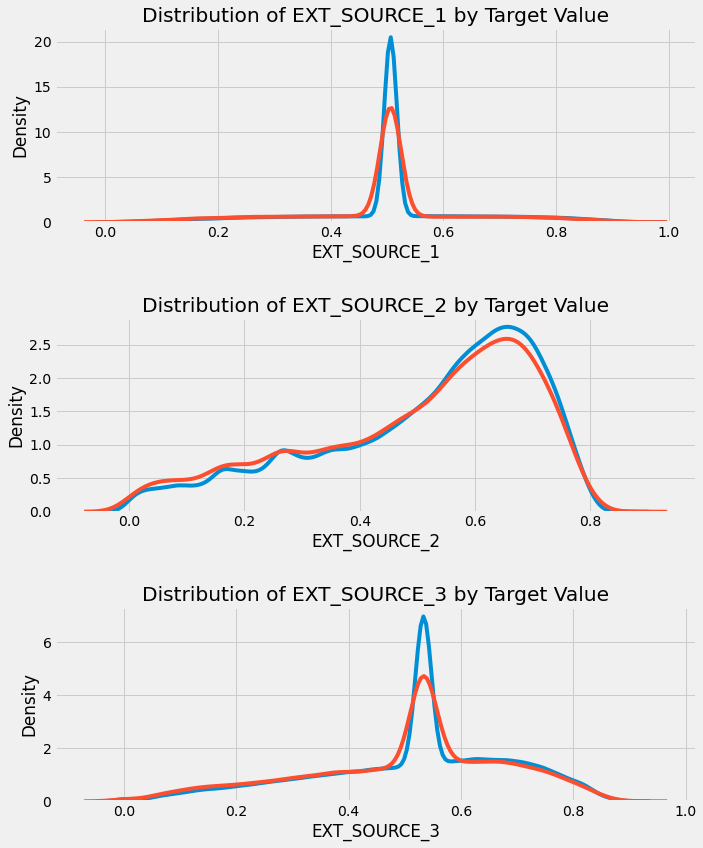

In [80]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_train_enc.loc[df_train_enc[target] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_train_enc.loc[df_train_enc[target] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [81]:
# Pairplot is quite heavy, thus we will draw it only wheter we need it (draw_pairplot = True)
draw_pairplot = False

if(draw_pairplot):
    
    start_time = fc.set_start()
    
    # Copy the data for plotting
    plot_data = df_ext_data.drop(columns = ['DAYS_BIRTH']).copy()

    # Add in the age of the client in years
    plot_data['YEARS_BIRTH'] = df_age['YEARS_BIRTH']

    # Drop na values and limit to first 100000 rows
    plot_data = plot_data.dropna().loc[:100000, :]

    # Function to calculate correlation coefficient between two columns
    def corr_func(x, y, **kwargs):
        r = np.corrcoef(x, y)[0][1]
        ax = plt.gca()
        ax.annotate("r = {:.2f}".format(r),
                    xy=(.2, .8), xycoords=ax.transAxes,
                    size = 20)

    # Create the pairgrid object
    grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                        hue = target, 
                        vars = [x for x in list(plot_data.columns) if x != target])

    # Upper is a scatter plot
    grid.map_upper(plt.scatter, alpha = 0.2)

    # Diagonal is a histogram
    grid.map_diag(sns.kdeplot)

    # Bottom is density plot
    grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

    plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05)
    
    text = "Pariplot drawn in [ela_time] sec."
    fc.print_time(text)

[back to table of contents](#tc)
## <a id="3.5"></a>3.5. Feature engeneering

### <a id="3.5.1"></a>3.5.1. Polynomial features

As suggested in <a href="https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook">Will Koehrsen's notebook</a>, these features can be used to build some new plynomial features. We will later see whether and how they will influence the quality of our modelization. 

In [82]:
# Make a new dataframe for polynomial features
poly_features = df_train_enc[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', target]]
poly_features_test = df_test_enc[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

In [83]:
df_merge = merge_train_test(df_train_enc, df_test_enc)
cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', target]
df_poly_feat = df_merge[cols]

poly_target = df_poly_feat[target]
poly_features = df_poly_feat.drop(columns = [target])
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [84]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
#poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (355120, 35)


In [85]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2', 'EXT_SOURCE_1^3',
       'EXT_SOURCE_1^2 EXT_SOURCE_2', 'EXT_SOURCE_1^2 EXT_SOURCE_3',
       'EXT_SOURCE_1^2 DAYS_BIRTH', 'EXT_SOURCE_1 EXT_SOURCE_2^2',
       'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
       'EXT_SOURCE_1 EXT_SOURCE_3^2',
       'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
       'EXT_SOURCE_1 DAYS_BIRTH^2', 'EXT_SOURCE_2^3',
       'EXT_SOURCE_2^2 EXT_SOURCE_3', 'EXT_SOURCE_2^2 DAYS_BIRTH',
       'EXT_SOURCE_2 EXT_SOURCE_3^2',
       'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
       'EXT_SOURCE_2 DAYS_BIRTH^2', 'EXT_SOURCE_3^3',
       'EXT_SOURCE_3^2 DAYS_BIRTH', 'EXT_SOURCE_3 DAYS_BIR

In [86]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))
# Add in the target
poly_features[target] = poly_target.values

# Find the correlations with the target
poly_corrs = poly_features.corr()[target].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_3^2 DAYS_BIRTH              -0.034312
EXT_SOURCE_3 DAYS_BIRTH^2              -0.034109
EXT_SOURCE_3 DAYS_BIRTH                -0.034081
EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH   -0.032016
EXT_SOURCE_1 DAYS_BIRTH^2              -0.026216
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH   -0.026189
EXT_SOURCE_3^3                         -0.025362
EXT_SOURCE_3^2                         -0.025113
DAYS_BIRTH^2                           -0.023873
DAYS_BIRTH^3                           -0.023745
Name: TARGET, dtype: float64
EXT_SOURCE_1^2 EXT_SOURCE_2    0.004447
EXT_SOURCE_1^2                 0.004721
EXT_SOURCE_1^3                 0.012071
TARGET                         1.000000
1                                   NaN
Name: TARGET, dtype: float64


In [87]:
# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = df_merge['SK_ID_CURR'].values
df_merge = df_merge.merge(poly_features, on = ['SK_ID_CURR', target], how = 'left')

df_train_poly, df_test_poly = split_train_test(df_merge)

# Print out the new shapes
fc.print_shape(df_train_poly, 'training data with polynomial features')
fc.print_shape(df_test_poly, 'testing data with polynomial features')

The dataframe (training data with polynomial features) contains 306540 rows and 614 columns.
The dataframe (testing data with polynomial features) contains 48580 rows and 613 columns.


In [88]:
# Export data to files (.csv)
store_data(df_train_poly, 'train_poly')
store_data(df_test_poly, 'test_poly')

Data storage (./data/cleaned/data_train_poly.csv): ok.
Data storage (./data/cleaned/data_test_poly.csv): ok.


[back to table of contents](#tc)
### <a id="3.5.2"></a>3.5.2. Domain knowledge features

One more time, we will follow <a href="https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook">Will Koehrsen's notebook</a>, and build some other domain features, whose impact will be also later tested. 

In [89]:
df_merge = merge_train_test(df_train_enc, df_test_enc)

df_merge['CREDIT_INCOME_PERCENT'] = df_merge['AMT_CREDIT'] / df_merge['AMT_INCOME_TOTAL']
df_merge['ANNUITY_INCOME_PERCENT'] = df_merge['AMT_ANNUITY'] / df_merge['AMT_INCOME_TOTAL']
df_merge['CREDIT_TERM'] = df_merge['AMT_ANNUITY'] / df_merge['AMT_CREDIT']
df_merge['DAYS_EMPLOYED_PERCENT'] = df_merge['DAYS_EMPLOYED'] / df_merge['DAYS_BIRTH']

df_train_domain, df_test_domain = split_train_test(df_merge)

# Print out the new shapes
fc.print_shape(df_train_domain, 'training data with domain features')
fc.print_shape(df_test_domain, 'testing data with domain features')

The dataframe (training data with domain features) contains 306540 rows and 583 columns.
The dataframe (testing data with domain features) contains 48580 rows and 582 columns.


In [90]:
# Export data to files (.csv)
store_data(df_train_domain, 'train_domain')
store_data(df_test_domain, 'test_domain')

Data storage (./data/cleaned/data_train_domain.csv): ok.
Data storage (./data/cleaned/data_test_domain.csv): ok.


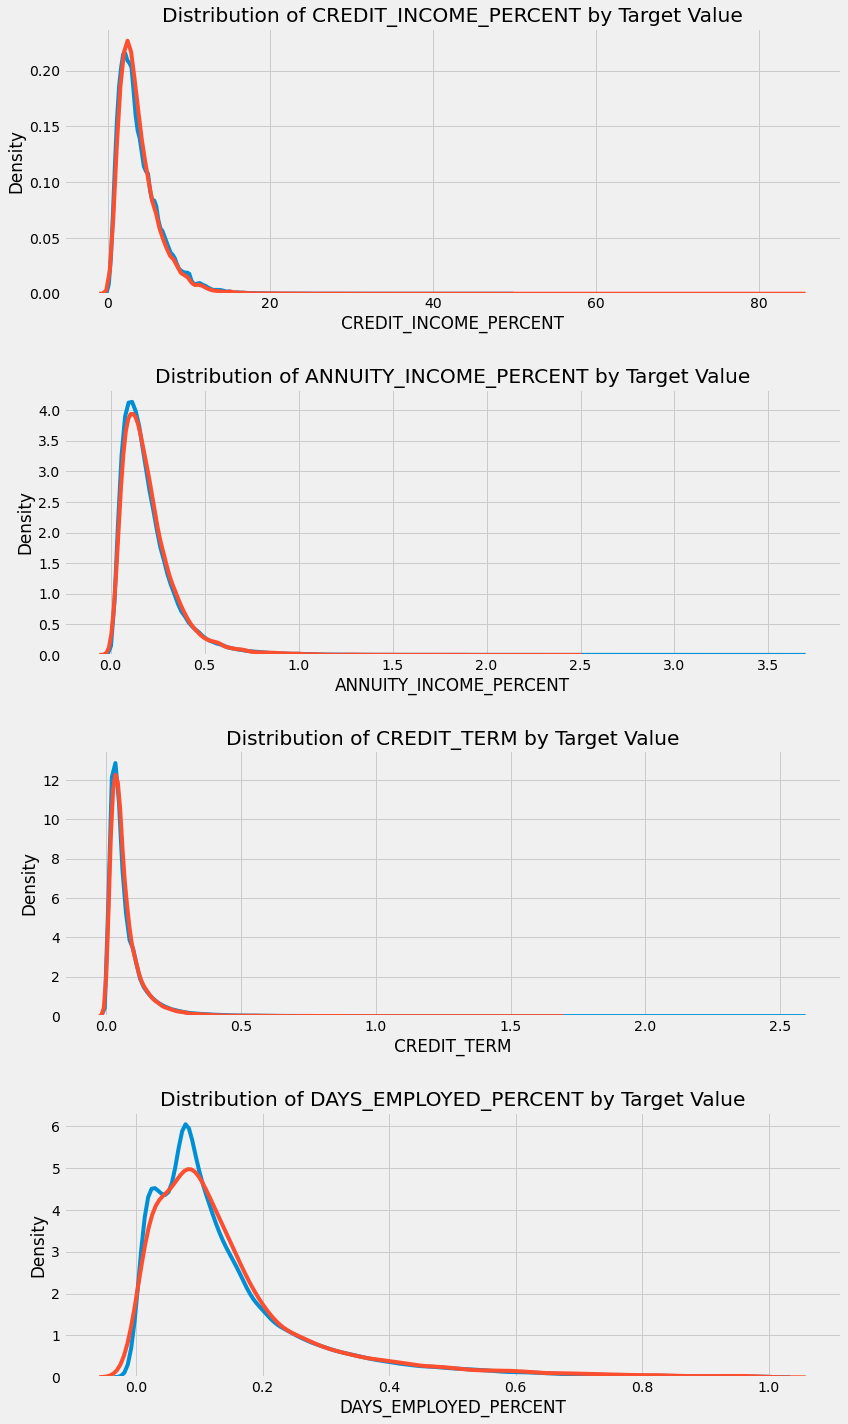

In [91]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_train_domain.loc[df_train_domain[target] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_train_domain.loc[df_train_domain[target] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

[back to table of contents](#tc)
# <a id="4"></a>4. Modelization

We will train and test three different models:

- <a href="https://en.wikipedia.org/wiki/Logistic_regression">Logistic Regression</a>;
- <a href="https://en.wikipedia.org/wiki/Random_forest">Random Forest</a>;
- <a href="https://en.wikipedia.org/wiki/LightGBM">Light Gradient-Boosting Machine</a>.

Since we have to deal with an very unbalanced dataset (see above, [§ 3.1](#3.1)), we will set the class weight parameter of Logistic Regression and Light GBM classifiers as <i>balanced</i>; since <a href="https://scikit-learn.org/">ScikitLearn</a>'s <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">RandomForestClassifier</a> has not such parameter, we will use instead <a href="https://imbalanced-learn.org/">ImbalancedLearn</a>'s <a href="https://imbalanced-learn.org/dev/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html">BalancedRandomForestClassifier</a>.<br>
Every model will be tested on three versions of our dataset:

- Standard dataset;
- Dataset including polynomial features;
- Dataset including domain features.

Furthermore, since after data merge and new features creationt the number of our columns exploded (> 500), we will test the role, which a PCA would play in our modelization, in terms of time gain and prediction quality loss.

As to models evaluation, we consider both "classic" metrics, such as accuracy and AUC ROC, and a new score, specifically conceived and designed for our problem, which we will call <i><b>Petitta score</b></i> (<b>PS</b>), from the surname of the main author of the paper, which inspired it (Petitta, F. <i>et al</i>., A., <i>Tools and metrics for Data-driven Operational Knowledge (DOK)</i>, in «Central European Journal of Applied Mathematics and Statistics», forthcoming).<br>
In short, the main principle of PS, is to assign different weights to both False Positive* Rate** (FPR) and False Negative Rate (FNR), so that the costs related to them adapt to the specific problem. In our case, TPR and FPR will have respectively 1 and 10 as weights. Then, in our implementation, the sum of weighted FPR an TPR is subtracted to the maximum possible cost (defined as the sum of weighted FPR and FNR in the worst scenario: in our case, 100% of positive values, detected as negative), then divided again for the maximum possible cost, in order to respect a range spanning from 0 an 1, and to respect the principle "bigger is better".
_______________
\* Positive (1) 'credit applicant who won't pay or will have problems to pay on time'; negative (0): credit applicant, who won't have any problem to pay on time.

\** As (false positive/negative) rate, we mean the raw (positive/negative) count, not the percentage.

In [92]:
# Applies PC to given training and testing sets
def train_test_pca(X_train, X_test, X_pca=None, n_comp_pca=0.99, print_res=True):
    
    start_time = fc.set_start()
        
    n_feat = X_train.shape[1]
    len_X_train = len(X_train)
    
    if(X_pca==None):
        
        if(print_res):
            print(f">>> PCA ({n_comp_pca}) in progress...\n")
        
        X_merge = np.concatenate((X_train, X_test))
        pca = PCA(n_components=n_comp_pca)
        X_merge = pca.fit_transform(X_merge)
        X_train_red = X_merge[:len_X_train]
        X_test_red = X_merge[len_X_train:]
    
    else:
        
        X_train_red, X_test_red = X_pca
        
    n_feat_pca = X_train_red.shape[1]
    feat_diff = n_feat - n_feat_pca
    
    if(print_res==True):
        text = f"PCA ({n_comp_pca}): OK ({feat_diff} features less). Time: [ela_time] sec.\n"
        fc.print_time(text=text, start_time=start_time)
                
    return X_train_red, X_test_red

In [93]:
# Creating training and testing sets
def create_train_test_set(df, scaler=None, ts=0.3, rs=69, calc_pca=True, n_comp_pca=0.99, print_res=True):
    X = df.copy()
    y = X[target]
    cols_to_drop = [target]
    if('SK_ID_CURR' in X.columns):
        cols_to_drop.append('SK_ID_CURR')
    X.drop(columns=cols_to_drop, inplace=True)
    if(scaler!=None):
        X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=rs)
    train_test_set = [X_train, X_test, y_train, y_test]
    if(calc_pca):
        X_train_red, X_test_red = train_test_pca(X_train, X_test, n_comp_pca=n_comp_pca, print_res=print_res)
        train_test_set.append(X_train_red)
        train_test_set.append(X_test_red)
    return train_test_set

In [94]:
# Data scaling
scaler = StandardScaler()

In [152]:
# Creation of the tra
#train_test_set_std = create_train_test_set(df_train_enc, scaler, n_comp_pca=0.80)
#train_test_set_poly = create_train_test_set(df_train_poly, scaler, n_comp_pca=0.80)
train_test_set_domain = create_train_test_set(df_train_domain, scaler, n_comp_pca=0.80)

>>> PCA (0.8) in progress...



MemoryError: Unable to allocate 1.33 GiB for an array with shape (306540, 581) and data type float64

In [97]:
# If set to False, this boolean will tell the algorithm, instead to perform calculations, to get the previous results,
# which are stored in ./calc/.
calc_pred = False

In [98]:
# Returns a string with the model name (from a model class)
def get_model_name(model, sep='('):
    model_name = str(model).split(sep)[0]
    return model_name

In [99]:
# Returns the name (with path) of a storage file (for GridSearchCV or predictions result)
def get_filename(model_name, obj, loc=calc_path, dataset="standard", app_pca=False, ext='.csv'):
    filename = loc + model_name + obj + dataset.capitalize() 
    if(app_pca):
        filename += 'PCA'
    filename += ext
    return filename

In [100]:
# Stores GridSearchCV or predictions result in a file
def store_val(values, obj, cols, filename, sep="\t", index=None, print_res=True):
    df = pd.DataFrame(columns=cols)
    df.loc[0] = values
    df.to_csv(filename, sep=sep, index=index)
    if(print_res):
        print(f"{obj} storage: OK ({filename}).\n")

In [101]:
# Stores treshold optimization tests in a file
def store_treshold_opt(treshold_list, score_list, filename, sep="\t", index=None, print_res=True):
    cols = ['treshold', 'score']
    df = pd.DataFrame(columns=cols)
    n_rows = len(treshold_list)
    for i in range(n_rows):
        df.loc[i] = [treshold_list[i], score_list[i]]
    df.to_csv(filename, sep=sep, index=index)
    if(print_res):
        print(f"{n_rows} treshold list optimization tests succesfully stored ({filename}).\n")

In [102]:
# Recovers a confusion matrix array from a storage file (where it is stored as a string)
def get_cm(cm_string, sep_a=']\n [', sep_b=" "):
    cm_string = re.sub(' +', ' ', cm_string)
    cm_string = cm_string[2:-2]
    cm_string_split = cm_string.split(sep_a)
    for i in range(len(cm_string_split)):
        cm_string_split[i] = cm_string_split[i].lstrip(' ')
    cm_string_split_1 = cm_string_split[0].split(sep_b)
    cm_string_split_2 = cm_string_split[1].split(sep_b)
    
    def to_int(cm_str_split):
        for i in range(len(cm_str_split)):
            cm_str_split[i] = int(cm_str_split[i])
        return cm_str_split
    
    cm_string_split_1 = to_int(cm_string_split_1)
    cm_string_split_2 = to_int(cm_string_split_2)
    
    cm_list = []
    cm_list.append(cm_string_split_1)
    cm_list.append(cm_string_split_2)
    cm = np.array(cm_list)
    
    return cm

In [103]:
# Recovers a predictions array from a storage file (where it is stored as a string) 
def get_y(y_string, sep=' '):
    y_string = y_string[1:-1]
    y = y_string.split(sep)
    y = np.array(list((map(int, y))))
    return y

In [104]:
# Convert a list to string
def list_to_string(l):
    l_str = '['
    for i, n in enumerate(l):
        l_str += str(n) + ' '
    l_str = l_str[:-1] + ']'
    return l_str

In [105]:
# Recovers an array from a string
def string_to_array(string, sep=' ', typ=np.float64):
    arr = np.array(string.split(sep))
    float_list = []
    for elt in arr:
        elt = typ(elt)
        float_list.append(elt)
    return np.array(float_list)

In [106]:
# Recovers (false/true) prediction rate array from string
def get_pr(df, col, limits='[]', sep=' ', typ=np.float64):
    limit_1, limit_2 = limits
    string = df[col].iloc[0]
    string = string.split(limit_1)[1]
    string = string.split(limit_2)[0]
    pr_arr = string_to_array(string, sep=sep, typ=typ)
    return pr_arr

In [107]:
# Specific score (so-called Petitta score) function
def spec_score_func(y_true, y_pred, w_fp=1, w_fn=10):
    
    n_pred = len(y_true)
    
    cm = confusion_matrix(y_true, y_pred)
    
    if(len(cm)==2):
        tn, fp, fn, tp = cm.ravel()
    else:
        fp = 0
        fn = 0
    
    wfp = fp * w_fp
    wfn = fn * w_fn
    
    max_cost_coef = max(w_fn, w_fp)
    
    max_cost = n_pred * max_cost_coef
    
    score = (max_cost - (wfp + wfn)) / max_cost
    
    return score

spec_score_name = 'petitta'
spec_score_data = [spec_score_name, spec_score_func]

In [108]:
# Returns, for a given model test, a name and a description
def get_test_info(model_name, dataset_type, app_pca):
    
    name = f"{model_name}/{dataset_type} dataset"
    description = f"{model_name} on {dataset_type} dataset"
    if(app_pca):
        name += "/PCA"
        description += " with PCA"
    dt_str = fc.get_date_time()
    description += f" [{dt_str}]"
     
    return name, description

In [109]:
# Plots CM heatmap
def plot_cm(cm, test_name, figsize=(6,4)):
    
    plt.figure(figsize = (6,4))
    
    sns.heatmap(cm, annot=True, cmap="Blues")
    
    plt.title(f'Confusion matrix [{test_name}]')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    
    plt.show()

In [110]:
# Plots ROC curve chart
def plot_roc_auc(roc_auc, fpr, tpr, test_name, figsize=(6,4)):
    
    plt.figure(figsize = figsize)
    
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    plt.title(f'ROC curve [{test_name}]')
    plt.legend(loc = 'lower right')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    
    plt.show()

In [111]:
# Cross validate a given classifier on a given parameters grid on a given dataset. Returns the best parameters
# PCA is optional (app_pca=True; default: False)
def cross_validate(model,
                   train_test_set, 
                   param_grid,
                   dataset="standard",
                   score_spec=spec_score_data,
                   cv=10, 
                   print_res=True,
                   calc=calc_pred,
                   store=True,
                   loc=calc_path,
                   sep='(',
                   ext='.csv',
                   r=4,
                   app_pca=False,
                   n_comp_pca=0.99):
    
    # Execution start time
    start_time = fc.set_start()
    
    # Object (cross validation) and model names (for result printing and storing)
    obj = "CV"
    model_name = get_model_name(model)
    
    # Score name and function
    score_name = score_spec[0]
    score_tool = make_scorer(score_spec[1], greater_is_better=True)
    
    # Name of the file storing cv
    filename = get_filename(model_name=model_name, obj=obj, loc=loc, dataset=dataset)
    
    # Name and description of the model test
    test_name, test_description = get_test_info(model_name, dataset, app_pca)
    
    # Getting training set
    
    # If PCA is demanded (app_pca=True), either an X train, on which PCA has been already performed is selected, or PCA
    # is performed on X train
    if(app_pca):
            
        if(len(train_test_set)==6):
            X_pca = train_test_set[4:]
        else:
            X_pca = None
        
        X_train, X_test = train_test_set[0:2]
        X_train, X_test = train_test_pca(X_train, X_test, X_pca=X_pca, n_comp_pca=n_comp_pca, print_res=False)
        X = X_train
    
    else:
        
        X = train_test_set[0]
        
    y = train_test_set[2]
        
    # Print CV in progress
    if(print_res):
        
        text = f">>> Cross validation [{test_name}] in progress...\n"
        print(text)
    
    # Parameters optimization
    if(calc):
        
        grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=score_tool)
        grid.fit(X, y)
        best_params = grid.best_params_
        best_score = grid.best_score_
        ela_time = fc.calc_time(start_time)
    
    # Results of a former parameters optimization are loaded
    else:
        
        df = pd.read_csv(filename, sep="\t")
        best_params = df['best_params'].iloc[0]
        best_params = ast.literal_eval(best_params)
        best_score = df['best_score'].iloc[0]
        ela_time = df['elapsed_time'].iloc[0]
    
    # Print result
    if(print_res):
        
        text = f"[{test_name}] Best hyperparameters: {best_params}; "
        text += f"best score ({score_name}): {round(best_score, r)}; time: [ela_time] sec.\n"
        fc.print_time(text=text, ela_time=ela_time)
        
    # Export result to file (.csv)
    if(calc & store):
        
        values = [model, model_name, best_params, best_score, ela_time]
        cols = ['model', 'model_name', 'best_params', 'best_score', 'elapsed_time']
        obj = "Cross validation result"
        store_val(values, obj, cols, filename)
    
    # Return result (optimized parameters)
    return best_params

In [112]:
# Assigns classes accoording to a given treshold (default: 0.5)
def assign_class(y_proba, treshold=0.5):
    
    y_pred = np.where(y_proba > treshold, 1, 0)
            
    #y_pred = y_pred.astype(int)
    
    return y_pred

In [113]:
# Loads parameters on MLFlow
def mlflow_log_params(params):
    for k,v in params.items():
        mlflow.log_param(k, v)

In [114]:
# Trains and tests a given classifier. Returns prediction results, accuracy and elapsed times
# Options: perform PCA (default: False)
#          plot confusion matrix heatmap and ROC curve chart (default: True)
#          track test on MLFlow (default: True)
def test(   model, 
            params, 
            train_test_set,
            dataset="standard",
            score_spec=spec_score_data,
            print_res=True,
            calc=calc_pred,
            store=True, 
            loc=calc_path, 
            r=4,
            treshold=0.5,
            app_pca=False,
            n_comp_pca=0.99,
            plot=True,
            track_test=True,
            test_description=None):
    
    # Object (cross validation) and model names (for result printing and storing)
    obj = "Prediction"
    model_name = get_model_name(model)
    
    # Score name and function
    score_name = score_spec[0]
    score_tool = score_spec[1]
    
    # Name and description of the model test
    test_name, td = get_test_info(model_name, dataset, app_pca)
    
    # If no description is passed as argument, a test description is automatically defined
    if(test_description==None):
        test_description = td
    
    # Name of the file storing result
    filename = get_filename(model_name=model_name, obj=obj, loc=loc, dataset=dataset, app_pca=app_pca)
    
    if(print_res):
        pred_in_prog = f">>> Prediction [{test_name}] in progress...\n"
    
    # Train and test performing
    if(calc):

        # Getting training and testing set
        X_train, X_test, y_train, y_test = train_test_set[0:4]
        
        # If PCA is demanded (app_pca=True), either an X train, on which PCA has been already performed is selected, 
        # or PCA is performed on X train
        if(app_pca):

            if(len(train_test_set)==6):
                X_pca = train_test_set[4:]
            else:
                X_pca = None

            X_train, X_test = train_test_pca(X_train, X_test, X_pca=X_pca, n_comp_pca=n_comp_pca, print_res=print_res)
        
        with mlflow.start_run(run_name=test_name, description=test_description):
            
            # Execution start time
            start_time = fc.set_start()

            # Setting classifier hyperparameters
            model.set_params(**params)

            # Training
            model.fit(X_train, y_train)

            # Prediction
            
            # Print CV in progress
            if(print_res):
                print(pred_in_prog)
            
            # Classes (0/1) probability
            y_proba = model.predict_proba(X_test)[:, 1]
            
            # Class prediction
            y_pred = assign_class(y_proba, treshold)

            # Evaluation (confusion matrix, custom score, accuracy, roc auc, time)
            cm = confusion_matrix(y_test, y_pred)
            score_spec = score_tool(y_test, y_pred)
            acc = accuracy_score(y_test, y_pred)
            fpr, tpr, threshold = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            roc_auc_sc = roc_auc_score(y_test, y_pred)
            ela_time = fc.calc_time(start_time)
            
            # MLFlow tracking
            mlflow.log_metric(f"{score_name} score", score_spec)
            mlflow.log_metric("accuracy", acc)
            mlflow.log_metric("ROC AUC score", roc_auc_sc)
            mlflow.log_metric("elapsed seconds", ela_time)
            mlflow_log_params(params)

            predictions = model.predict(X_train)
            signature = infer_signature(X_train, predictions)

            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                # Register the model
                # There are other ways to use the Model Registry, which depends on the use case,
                # please refer to the doc for more information:
                # https://mlflow.org/docs/latest/model-registry.html#api-workflow
                mlflow.sklearn.log_model(
                    model, "model", registered_model_name=model_name, signature=signature
                )
            else:
                mlflow.sklearn.log_model(model, "model", signature=signature)
    
    # Test result is loaded from storage file
    else:
        
        start_time = fc.set_start()

        if(print_res):
            if(app_pca):
                print(f"PCA ({n_comp_pca}): OK.\n")
            print(pred_in_prog)

        df = pd.read_csv(filename, sep="\t")
        y_pred = df['y_pred'].iloc[0]
        cm = df['confusion_matrix'].iloc[0]
        cm = get_cm(cm)
        score_spec = df['score_spec'].iloc[0]
        acc = df['accuracy'].iloc[0]
        fpr = get_pr(df, 'fpr')
        tpr = get_pr(df, 'tpr')
        roc_auc = df['roc_auc'].iloc[0]
        roc_auc_sc = df['roc_auc_score'].iloc[0]
        ela_time = df['elapsed_time'].iloc[0]
    
    # Print result
    if(print_res):
        
        text  = f"[{test_name}] {score_name.capitalize()} score: {round(score_spec, r)}"
        text += f"\n[{test_name}] Accuracy score: {round(acc, r)}"
        text += f"\n[{test_name}] ROC AUC score: {round(roc_auc_sc, r)}"
        text += f"\n[{test_name}] Time: [ela_time] sec.\n"
        
        fc.print_time(text=text, ela_time=ela_time)
        
    # Store result in list
    cols = ['model',
            'dataset_type', 
            'pca',
            'y_pred', 
            'score_spec', 
            'accuracy',
            'fpr',
            'tpr',
            'roc_auc',
            'roc_auc_score', 
            'confusion_matrix', 
            'elapsed_time']
    
    values = [model, dataset, app_pca, y_pred, score_spec, acc, fpr, tpr, roc_auc, roc_auc_sc, cm, ela_time]
    
    # Export result to file (.csv)
    if(calc & store):
        
        y_pred_str = list_to_string(list(y_pred))
        fpr_str = list_to_string(fpr)
        tpr_str = list_to_string(tpr)
        values_to_store = [model, dataset, app_pca, y_pred_str, score_spec, acc, fpr_str, tpr_str, roc_auc, roc_auc_sc, cm, ela_time]
        store_val(values_to_store, obj, cols, filename)
    
    # Plot confusion matrix heatmap and ROC AUC curve chart
    if(plot):
        figsize = (10,6)
        plot_cm(cm, test_name, figsize)
        plot_roc_auc(roc_auc, fpr, tpr, test_name, figsize)
    
    # Return result
    return zip(cols, values)

In [115]:
# Returns a parameters dictionary from a parameters grid (in the grid, multiple parameter values are stored in lists)
def get_params_from_grid(grid):
    params = dict()
    for key in grid:
        if(isinstance(grid[key], list)):
            params[key] = grid[key][0]
        else:
            params[key] = grid[key]
    return params

In [116]:
# For a given mode, this function performs three operations:
# 1) parameters optimization (optional; default: True)
# 2) train
# 3) test
# Other options: perform PCA (default: False)
#                plot confusion matrix heatmap and ROC curve chart (default: True)
#                track test on MLFlow (default: True) 
def apply_model(model,
                train_test_set, 
                param_grid,
                validate=True,
                dataset="standard",
                score_spec=spec_score_data, 
                cv=10, 
                print_res=True,
                store=True,
                loc=calc_path,
                sep='(',
                ext='.csv',
                calc=calc_pred,
                r=4,
                ret=False,
                treshold=0.5,
                app_pca=False,
                n_comp_pca=0.99,
                plot=True,
                track_test=True,
                test_description=None,
                get_params=False):
        
        # Cross validation
        if(validate):
            params =  cross_validate(  model, 
                                       train_test_set, 
                                       param_grid,
                                       dataset=dataset,
                                       score_spec=score_spec, 
                                       cv=cv, 
                                       print_res=print_res,
                                       calc=calc,
                                       store=store,
                                       loc=loc,
                                       sep=sep,
                                       ext=ext,
                                       r=r,
                                       app_pca=app_pca,
                                       n_comp_pca=n_comp_pca)
            
        else:
            params = get_params_from_grid(param_grid)
        
        # Prediction
        values = test(   model, 
                         params, 
                         train_test_set, 
                         dataset=dataset,
                         score_spec=score_spec,
                         print_res=print_res, 
                         calc=calc,
                         store=store, 
                         loc=loc, 
                         r=r,
                         treshold=treshold,
                         app_pca=app_pca,
                         n_comp_pca=n_comp_pca,
                         plot=plot,
                         track_test=track_test,
                         test_description=test_description)
        
        res = dict(values)
        
        if(ret):
            if(get_params):
                return res, params
            else:
                return res
        else:
            res_list.append(res)
            if(get_params):
                param_list.append(params)

In [117]:
# Tests results storage list
res_list = []
param_list = []

[back to table of contents](#tc)
## <a id="4.1"></a>4.1. Dummy Classifier (baseline)

Before testing out models, we implement a <a href="https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html">dummy classifier</a>, in order to establish a baseline. The default estimation strategy, named <i>prior</i>, is defined as follows on the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html">class documentation page</a>: «the predict method always returns the most frequent class label in the observed y argument passed to fit (like “most_frequent”). predict_proba always returns the empirical class distribution of y also known as the empirical class prior distribution».<br>
Instead of keeping it, we will test all avaliable strategies (<i>most_frequent</i>, <i>prior</i>, <i>stratified</i>, <i>uniform</i>, <i>constant</i>; constant value = 1), and choose the one giving the best results (in terms of Petitta score).<br>
Class assignment treshold is fixed at 0.5.

>>> Cross validation [DummyClassifier/standard dataset] in progress...

[DummyClassifier/standard dataset] Best hyperparameters: {'constant': 1, 'random_state': 69, 'strategy': 'most_frequent'}; best score (petitta): 0.9191; time: 16.0 sec.

>>> Prediction [DummyClassifier/standard dataset] in progress...

[DummyClassifier/standard dataset] Petitta score: 0.92
[DummyClassifier/standard dataset] Accuracy score: 0.92
[DummyClassifier/standard dataset] ROC AUC score: 0.5
[DummyClassifier/standard dataset] Time: 0.0 sec.



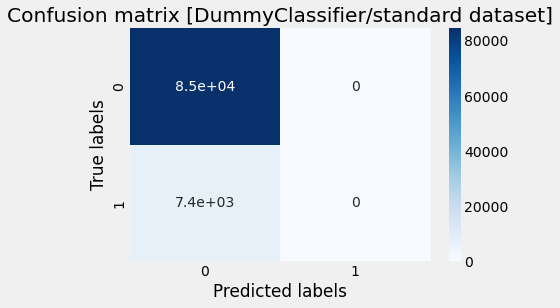

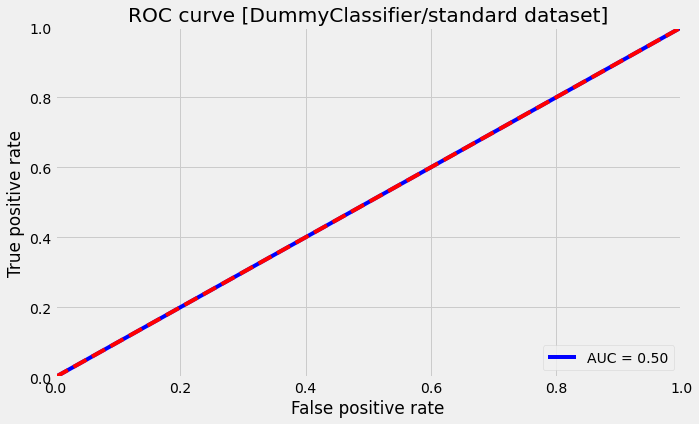

In [118]:
# Model definition
dummy = DummyClassifier(strategy='prior')

# Grid definition
strat_list = ['most_frequent', 'prior', 'stratified', 'uniform', 'constant'] # Best: most_frequent
dummy_grid = {'strategy': strat_list, 'random_state': [69], 'constant': [1]}

# Model optimization, train and test
apply_model(dummy, 
            train_test_set_std,
            dummy_grid,
            dataset='standard',
            app_pca=False,
            validate=True,
            plot=True,
            get_params=True)

Once our baseline defined, we will we will optimize some of our model's parameters (via GridSearchCV) on the standard dataset without PCA (as for the dummy classifier).<br>
Then, we will test them on the other all dataset versions (with/without polynomial/domain features; with/without PCA), in order to choose the best one.

[back to table of contents](#tc)
## <a id="4.2"></a>4.2. Logistic Regression

>>> Cross validation [LogisticRegression/standard dataset] in progress...

[LogisticRegression/standard dataset] Best hyperparameters: {'C': 0.001, 'class_weight': 'balanced'}; best score (petitta): 0.943; time: 275.0 sec.

>>> Prediction [LogisticRegression/standard dataset] in progress...

[LogisticRegression/standard dataset] Petitta score: 0.944
[LogisticRegression/standard dataset] Accuracy score: 0.6723
[LogisticRegression/standard dataset] ROC AUC score: 0.6747
[LogisticRegression/standard dataset] Time: 11.0 sec.



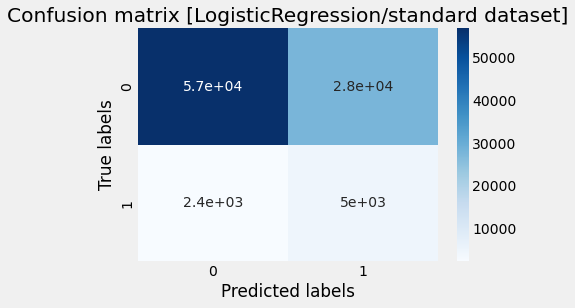

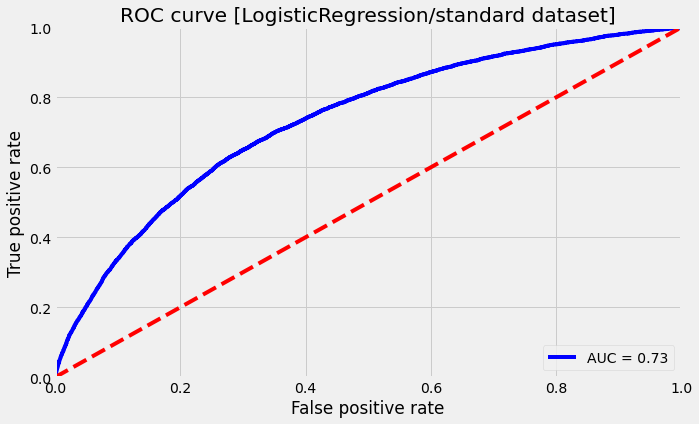

In [119]:
# Model definition
lr = LogisticRegression()

# Grid definition
C_list = [0.01, 0.001, 0.0001, 0.00001] # Best: 0.001
lr_grid = {'C': C_list, 'class_weight': ['balanced']}

# Model optimization, train and test
apply_model(lr, 
            train_test_set_std,
            lr_grid,
            dataset='standard',
            app_pca=False,
            validate=True,
            plot=True,
            get_params=True)

[back to table of contents](#tc)
## <a id="4.3"></a>4.3. (Balanced) Random Forest

>>> Cross validation [BalancedRandomForestClassifier/standard dataset] in progress...

[BalancedRandomForestClassifier/standard dataset] Best hyperparameters: {'n_estimators': 300}; best score (petitta): 0.9416; time: 2947.0 sec.

>>> Prediction [BalancedRandomForestClassifier/standard dataset] in progress...

[BalancedRandomForestClassifier/standard dataset] Petitta score: 0.9393
[BalancedRandomForestClassifier/standard dataset] Accuracy score: 0.6698
[BalancedRandomForestClassifier/standard dataset] ROC AUC score: 0.6452
[BalancedRandomForestClassifier/standard dataset] Time: 17.0 sec.



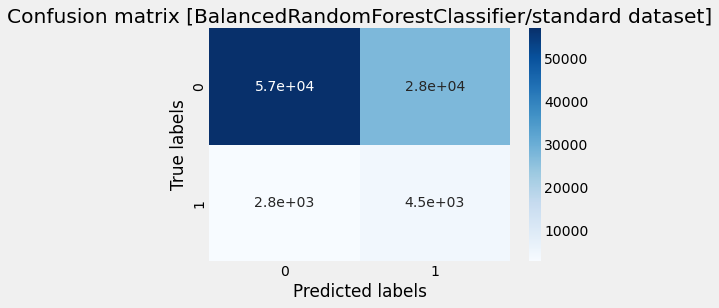

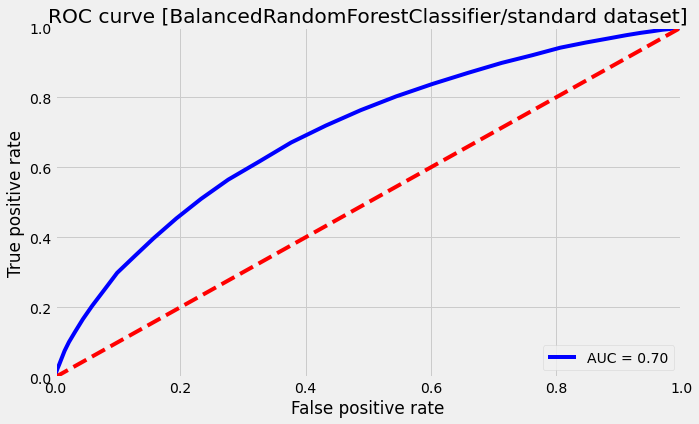

In [120]:
# Model definition
brf = BalancedRandomForestClassifier()

# Grid definition
n_estimator_list_brf = [50, 100, 150, 200, 250, 300] # Best: 300
brf_grid = {'n_estimators': n_estimator_list_brf}

# Model optimization, train and test
apply_model(brf, 
            train_test_set_std, 
            brf_grid,
            dataset='standard',
            validate=True,
            app_pca=False,
            plot=True,
            get_params=True)

[back to table of contents](#tc)
## <a id="4.4"></a>4.4. Light Gradient-Boosting Machine

>>> Cross validation [LGBMClassifier/standard dataset] in progress...

[LGBMClassifier/standard dataset] Best hyperparameters: {'class_weight': 'balanced', 'learning_rate': 0.05, 'n_estimators': 100, 'n_jobs': -1, 'objective': 'binary', 'random_state': 69, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}; best score (petitta): 0.9445; time: 50045.0 sec.

>>> Prediction [LGBMClassifier/standard dataset] in progress...

[LGBMClassifier/standard dataset] Petitta score: 0.9452
[LGBMClassifier/standard dataset] Accuracy score: 0.6948
[LGBMClassifier/standard dataset] ROC AUC score: 0.6804
[LGBMClassifier/standard dataset] Time: 11.0 sec.



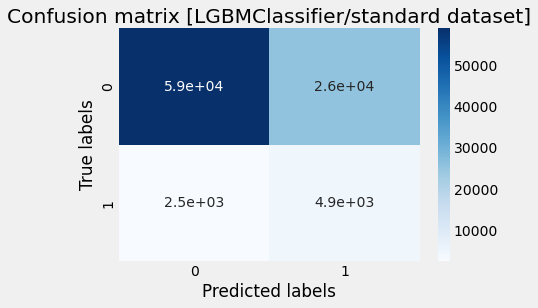

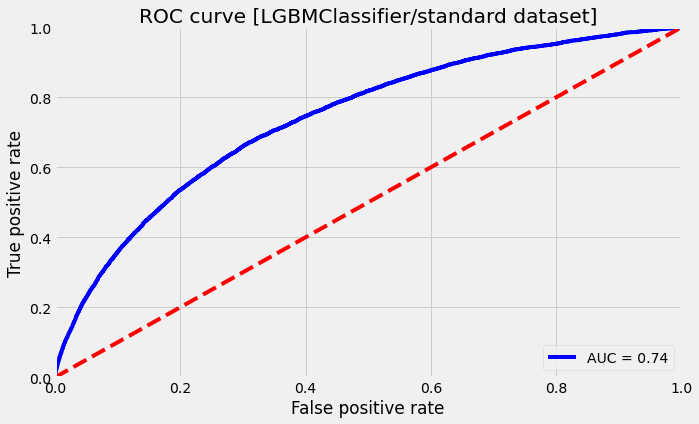

In [121]:
# Model definition
gb = LGBMClassifier()

# Grid definition
n_estimator_list_gb = [100, 1000, 10000] # Best: 100
gb_grid = {'n_estimators': n_estimator_list_gb, 
           'objective': ['binary'],            
           'class_weight': ['balanced'], 
           'learning_rate': [0.05], 
           'reg_alpha': [0.1],
           'reg_lambda': [0.1],
           'subsample': [0.8],
           'n_jobs': [-1],
           'random_state': [69]}

# Model optimization, train and test
apply_model(gb, 
            train_test_set_std, 
            gb_grid,
            dataset='standard',
            validate=True,
            app_pca=False,
            plot=True,
            get_params=True)

[back to table of contents](#tc)
## <a id="4.5"></a>4.5. Further tests
Once the parameters optimized, we go further with our tests.

In [122]:
# Further tests (without parameters optimization)
model_list = [dummy, lr, brf, gb]
train_test_set_list = [train_test_set_std, train_test_set_poly, train_test_set_domain]
set_type_list = ['standard', 'polynomial', 'domain']
app_pca_list = [True, False]
best_param_list = param_list
for n, model in enumerate(model_list):
    for i, train_test_set in enumerate(train_test_set_list):
        for app_pca in app_pca_list:
            if((i!=0)|(app_pca!=False)): # Standard dataset without PCA have already been tested
                apply_model(model, 
                            train_test_set, 
                            best_param_list[n],
                            dataset=set_type_list[i],
                            validate=False,
                            calc=calc_pred,
                            app_pca=app_pca,
                            plot=True)

NameError: name 'train_test_set_domain' is not defined

[back to table of contents](#tc)
## <a id="4.6"></a>4.6. Models and datasets comparing

In [123]:
def get_param_dict(model_list, param_list):
    param_dict = dict()
    for i, m in enumerate(model_list):
        param_dict[m] = param_list[i]
    return param_dict

In [124]:
param_dict = get_param_dict(model_list, param_list)

In [125]:
def get_comp_dict(res_list, param_dict):
    comp_dict = dict()
    for i, elt in enumerate(res_list):
        model_dataset = get_model_name(elt['model']) + elt['dataset_type'].capitalize()
        if(elt['pca']):
            model_dataset += 'PCA'
        comp_dict[model_dataset] = elt
        comp_dict[model_dataset]['model_name'] = get_model_name(comp_dict[model_dataset]['model'])
        params = param_dict[comp_dict[model_dataset]['model']]
        comp_dict[model_dataset]['params'] = params
    return comp_dict

In [126]:
def get_df_comp(res_list, param_dict):
    comp_dict = get_comp_dict(res_list, param_dict)
    cols = ['key', 'model', 'model_name', 'dataset_type', 'pca', 'score_spec', 'accuracy', 'roc_auc', 'elapsed_time', 'params']
    r = 4
    idx = list(np.arange(0,len(res_list)))
    df_comp = pd.DataFrame(columns=cols, index=idx)
    for i, elt in enumerate(comp_dict):
        df_comp.iloc[i][cols[0]] = elt
        for col in cols[1:]:
            #df_comp.iloc[i][col] = get_model_name(comp_dict[elt][col])
            df_comp.iloc[i][col] = comp_dict[elt][col]
    df_comp['score_spec'] = pd.to_numeric(df_comp['score_spec']).round(r)
    df_comp['accuracy'] = pd.to_numeric(df_comp['accuracy']).round(r)
    df_comp['roc_auc'] = pd.to_numeric(df_comp['roc_auc']).round(r)
    df_comp['elapsed_time'] = pd.to_numeric(df_comp['elapsed_time'])
    df_comp = df_comp.sort_values(['score_spec', 'accuracy', 'roc_auc', 'elapsed_time'], ascending=[False, False, False, True])
    return df_comp

In [127]:
df_comp = get_df_comp(res_list, param_dict)
cols_to_show = df_comp.columns[2:-1]
df_comp[cols_to_show]

,model_name,dataset_type,pca,score_spec,accuracy,roc_auc,elapsed_time
3,LGBMClassifier,standard,False,0.9452,0.6948,0.7403,11.0
1,LogisticRegression,standard,False,0.9440,0.6723,0.7323,11.0
2,BalancedRandomForestClassifier,standard,False,0.9393,0.6698,0.6989,17.0
0,DummyClassifier,standard,False,0.9200,0.9200,0.5000,0.0


In [128]:
def plot_compare(df, col, asc=False):
    df = df.sort_values(col, ascending=asc)
    fig = plt.figure(figsize=(20,9))
    plt.bar(x=df['key'], height=df[col])
    plt.xticks(rotation=80)
    max_val = df[col].max()
    title = f"Models and datasets comparison: {col}"
    plt.title(title)
    plt.show()

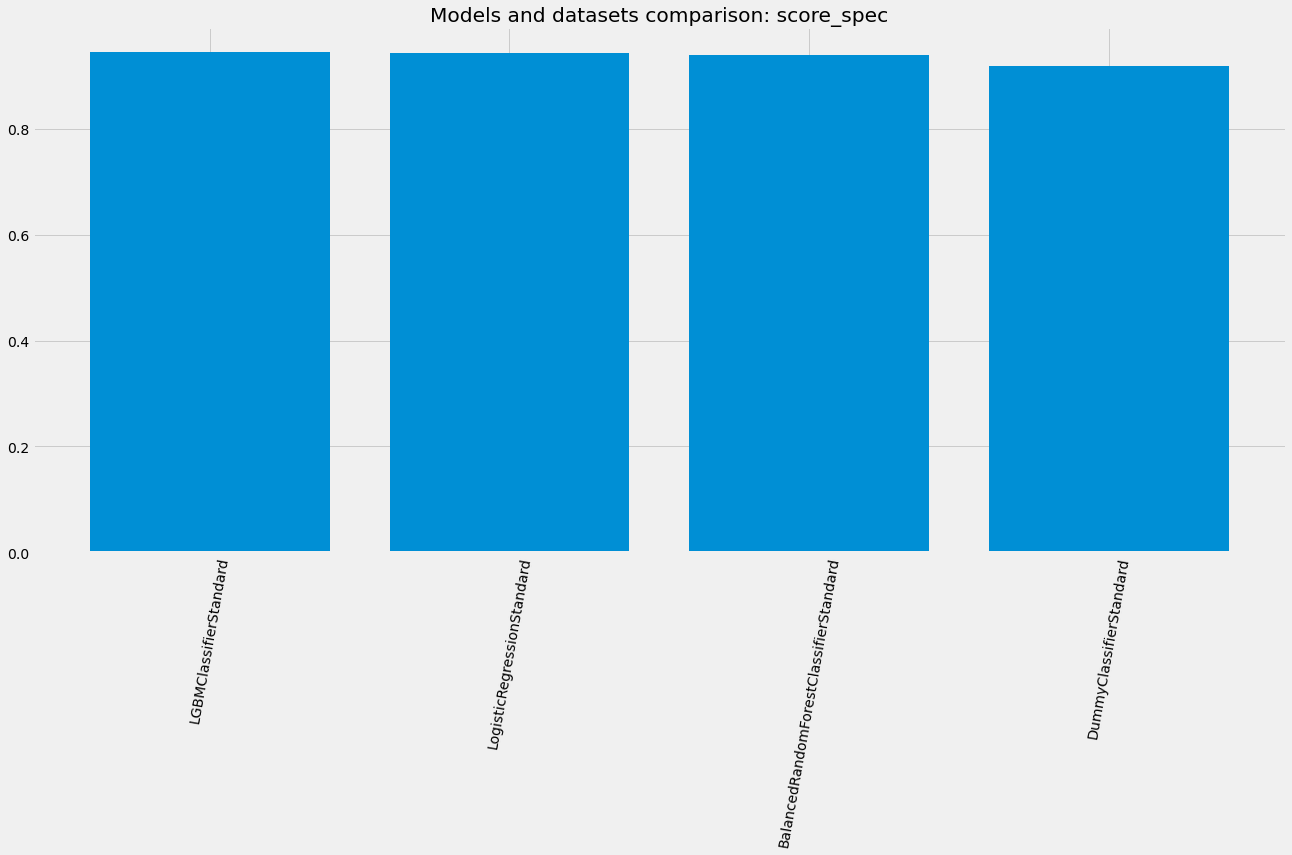

In [129]:
plot_compare(df_comp, 'score_spec')

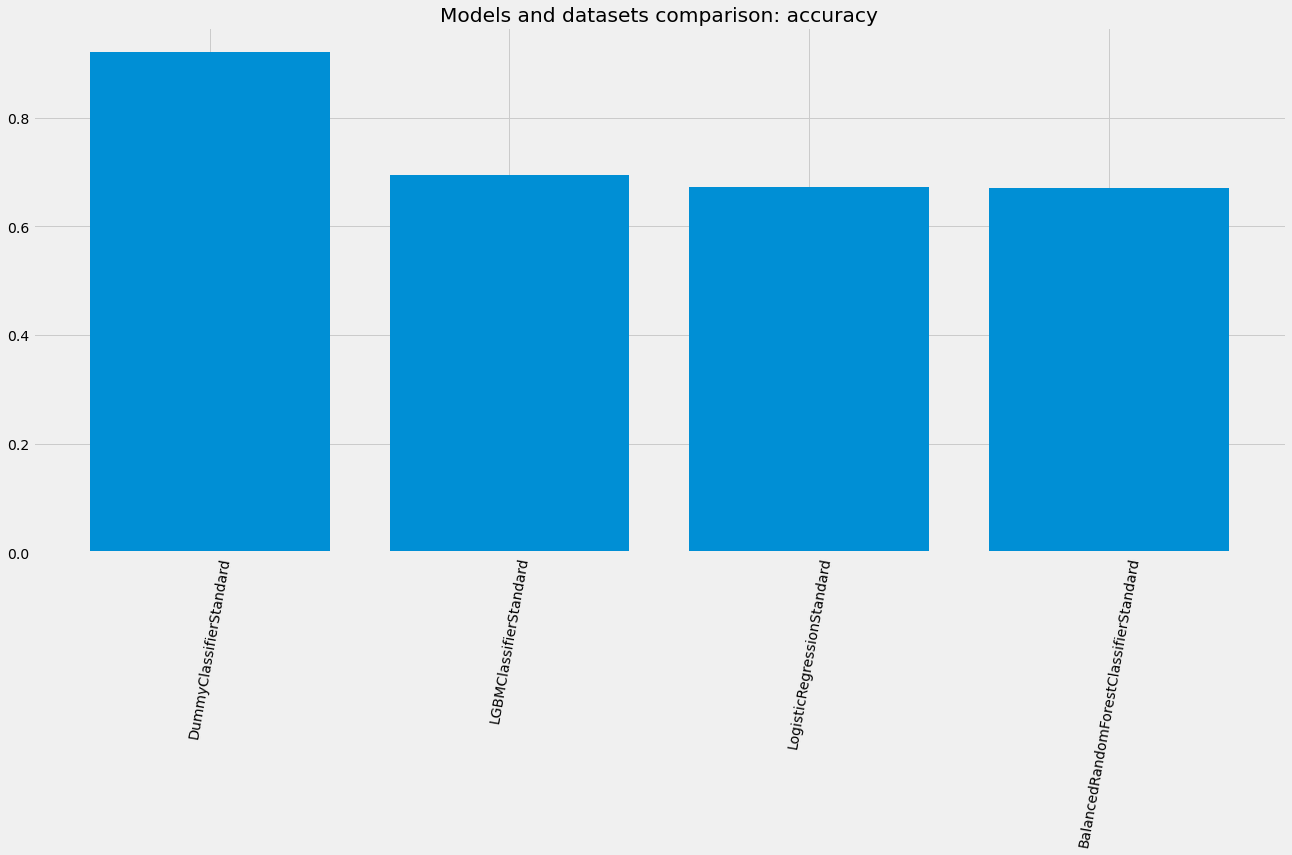

In [130]:
plot_compare(df_comp, 'accuracy')

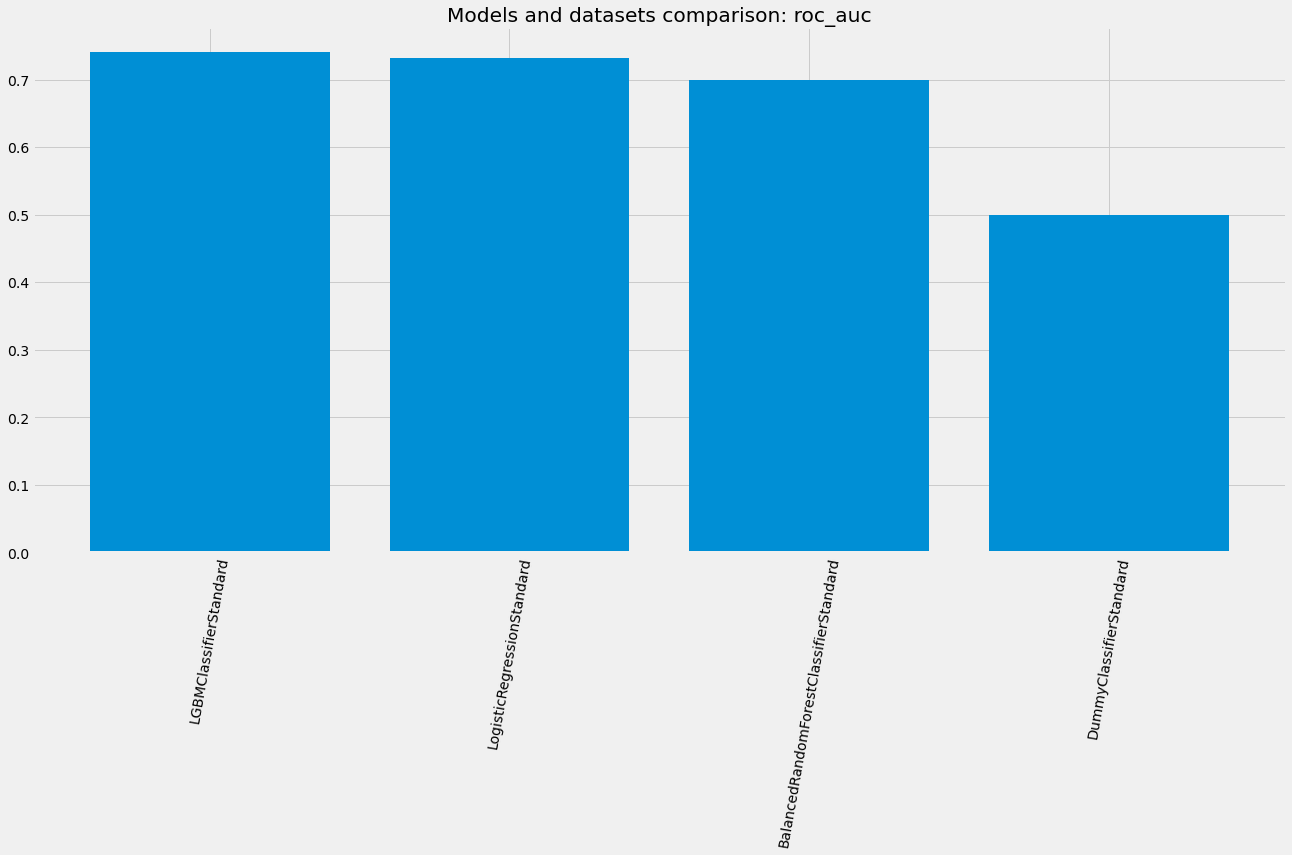

In [131]:
plot_compare(df_comp, 'roc_auc')

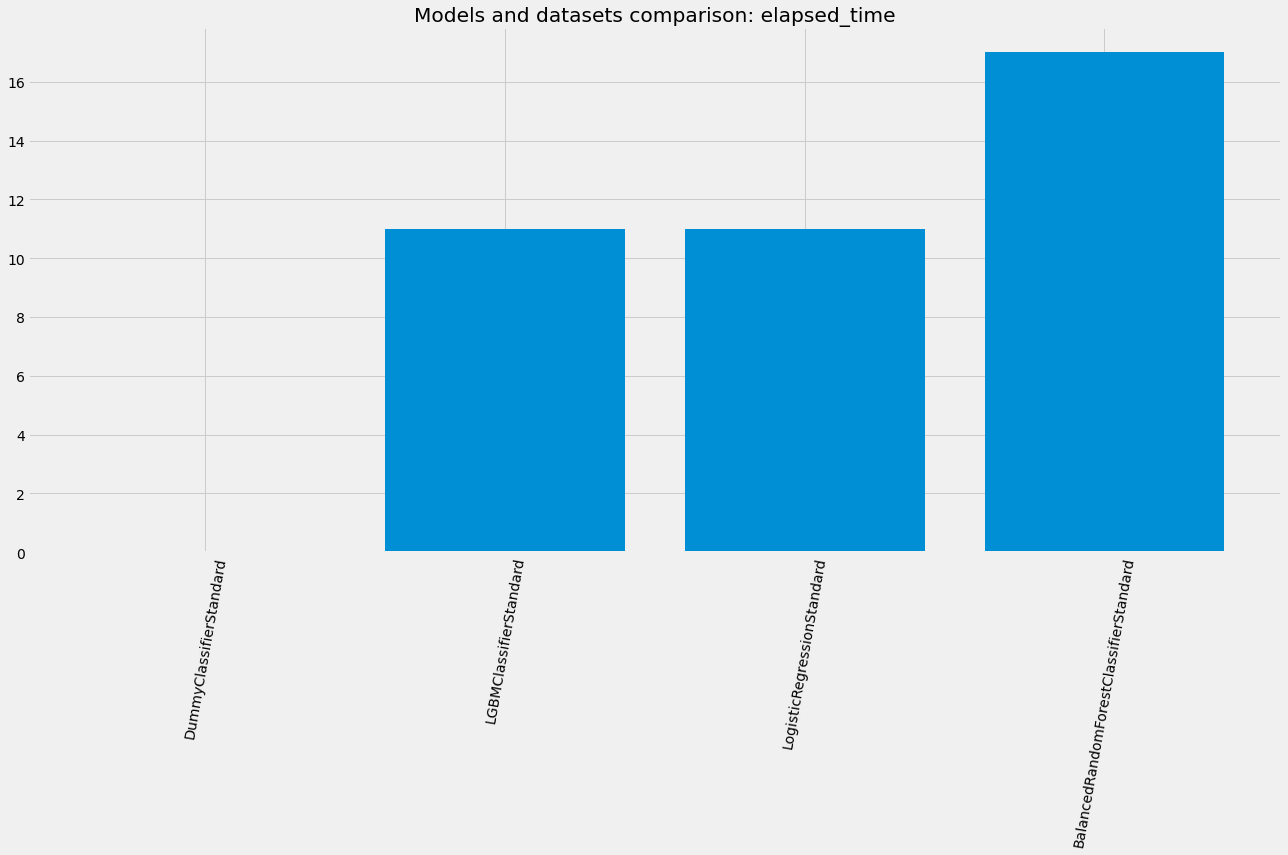

In [132]:
plot_compare(df_comp, 'elapsed_time', True)

Since our Petitta score is set in order to consider our business goals, we will use primarily it to choose our model.<br>
However, for the future official release, elapsed time could also be taken into account. Indeed, as we can see, there are significant differences, in terms of running time, between the combinations model/dataset.

In [133]:
# Getting the best score for further work
best_model, \
best_model_name, \
best_dataset_type, \
best_score, \
best_app_pca = df_comp.iloc[0][['model', 
                                'model_name', 
                                'dataset_type',
                                'score_spec',
                                'pca']]
best_train_test_set_idx = set_type_list.index(best_dataset_type)
best_train_test_set = train_test_set_list[best_train_test_set_idx]

pca_y_n = 'out'
if(best_app_pca):
    pca_y_n = ''
res  = f"The best model/dataset combination is {best_model_name} "
res += f"on {best_dataset_type} dataset with{pca_y_n} PCA ({spec_score_name} score: {best_score})."
print(res)

NameError: name 'set_type_list' is not defined

Despite this result, we will choose <b>Logistic Regression</b> as our final model; indeed, it keeps an excellent performance, and we have a significant gain in terms of execution time.

In [134]:
# Override best model
best_model = df_comp['model'].iloc[3]

[back to table of contents](#tc)
## <a id="4.7"></a>4.7. Treshold optimization

So far, we have assigned the class considering, as treshold, the standard value of 0.5. However, since the business cost of a false negative is much higher than the cost of a false positive, we can consider to move the treshold for classes assignation, in order to minimize the cost of our errors.<br>
Therefore, we will test some different tresholds (from 0 to 1), in order to choose the best one for our purpose.

In [135]:
# Testing tresholds
def get_best_treshold(model, 
                      train_test_set, 
                      app_pca=False, 
                      interval=0.1, 
                      dataset='standard', 
                      r=1, 
                      print_res=True, 
                      calc=calc_pred,
                      store=True,
                      loc=calc_path,
                      filename='TresholdOptimization',
                      ext='.csv'):
    
    filename = loc + filename + ext
    
    if(print_res):
        start_time = fc.set_start()
        print(f">>> Searching for the best treshold...\n")
    
    if(calc):
        
        treshold_list = np.arange(0, 1+interval, interval)
        
        model_name = get_model_name(model)
        params = param_dict[model]
        model = model.__class__()

        best_score = 0
        best_treshold = None

        score_list = []
    
    else:
        
        df_tr_opt = pd.read_csv(filename)
        df_tresh_opt = pd.read_csv(filename, sep="\t")
        treshold_list = df_tresh_opt['treshold'].tolist()
        score_list = df_tresh_opt['score'].tolist()
    
    n_test = len(treshold_list)
    spec_score_dict = dict()
    
    for i, t in enumerate(treshold_list):

        t = round(t,r)

        if(print_res):
            print(f">>> Test # {i+1}/{n_test} in progress...")
        
        if(calc):
            
            test_zip = test(    model, 
                                params, 
                                train_test_set=train_test_set, 
                                dataset=dataset,
                                print_res=False, 
                                calc=True,
                                store=False, 
                                treshold=t,
                                app_pca=app_pca,
                                plot=False,
                                test_description=f"Best model [{model_name}] treshold optimization [test # {i+1}/{n_test}]")

            test_dict = dict(test_zip)
            spec_score_dict[t] = test_dict['score_spec']

            if(spec_score_dict[t]>best_score):
                best_score = spec_score_dict[t]
                best_treshold = t
            
            current_score = spec_score_dict[t]  
            
        else:
            
            current_score = score_list[i]
            spec_score_dict[t] = current_score
            
        if(print_res):
            print(f"Test # {i+1}/{n_test} executed. Treshold: {t}; score: {current_score}")

    if(calc & store):
        
        score_list = list(spec_score_dict.values())
        store_treshold_opt(treshold_list, score_list, filename) 
    
    else:
        
        best_score = max(score_list)
        best_tresh_idx = score_list.index(best_score)
        best_treshold = treshold_list[best_tresh_idx]
        
    if(print_res):
        
        text  = f"\n{n_test} tests executed in [ela_time] sec. Best treshold: {best_treshold} "
        text += f"({spec_score_name} score: {best_score}).\n"
        fc.print_time(text=text, start_time=start_time)
        
    return spec_score_dict, best_treshold, best_score

In [136]:
spec_score_dict, best_treshold, best_score = get_best_treshold(best_model, 
                                                               best_train_test_set,
                                                               app_pca=best_app_pca)

NameError: name 'best_train_test_set' is not defined

In [137]:
# Comparing tresholds and scores
def plot_treshold_test(spec_score_dict, spec_score_name=spec_score_name):
    spec_score_name = f"{spec_score_name.capitalize()} score"
    treshold_list = spec_score_dict.keys()
    score_list = spec_score_dict.values()
    fig, ax = plt.subplots(figsize=(6, 5))
    plt.plot(treshold_list, score_list, label=spec_score_name)
    plt.axvline(x=best_treshold, color='k', dashes=(0.5, 1), 
                label="Best threshold: {}".format(best_treshold))
    title = f"{spec_score_name} depending on classifier treshold"
    plt.title(title, fontsize=10)
    plt.xlabel("Threshold", fontsize=10)
    plt.ylabel(spec_score_name, fontsize=10)
    plt.legend()
    plt.show()

In [138]:
plot_treshold_test(spec_score_dict)

NameError: name 'spec_score_dict' is not defined

Our tests confirm that the default treshold (0.5) is the most reliable.

[back to table of contents](#tc)
## <a id="4.8"></a>4.8. Pipeline

In order to associate our model to our API, we will create a pipeline, train it on our whole labelized dataset, and export it as a serialize object.

In [139]:
# Creating the training set
def create_pipeline_dataset(train_test_set, app_pca, print_res=True):
    X_idx = [0,1]
    if(app_pca):
        X_idx = [4,5]
    X_train_pipe = np.concatenate((train_test_set[X_idx[0]], train_test_set[X_idx[1]]))
    y_train_pipe = np.concatenate((train_test_set[2], train_test_set[3]))
    if(print_res):
        fc.print_shape(pd.DataFrame(X_train_pipe), "training set [X] for pipeline")
    return X_train_pipe, y_train_pipe

In [140]:
X_train_pipe, y_train_pipe = create_pipeline_dataset(best_train_test_set, best_app_pca)

NameError: name 'best_train_test_set' is not defined

In [141]:
'''
def get_x_y(train_test_set, apply_pca=True):
    
    if(apply_pca & (len(train_test_set_std)==6)):
        y_train, y_test, X_train, X_test = train_test_set_std[2:]
    else:
        X_train, X_test, y_train, y_test = train_test_set_std[:4]
    
    return X_train, X_test, y_train, y_test
    
    
X_train, X_test, y_train, y_test = get_x_y(train_test_set_std, apply_pca=False)
'''

'\ndef get_x_y(train_test_set, apply_pca=True):\n    \n    if(apply_pca & (len(train_test_set_std)==6)):\n        y_train, y_test, X_train, X_test = train_test_set_std[2:]\n    else:\n        X_train, X_test, y_train, y_test = train_test_set_std[:4]\n    \n    return X_train, X_test, y_train, y_test\n    \n    \nX_train, X_test, y_train, y_test = get_x_y(train_test_set_std, apply_pca=False)\n'

In [142]:
def empty_folder(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [143]:
# Final model instance
final_model = best_model.__class__()
final_params = param_dict[best_model]
final_model.set_params(**final_params)

DummyClassifier(constant=1, random_state=69, strategy='most_frequent')

In [144]:
def create_pipeline(model, X, y, path=model_path, filename='model.pkl', calc=calc_pred, print_res=True):

    if(print_res):
        start_time = fc.set_start()
    
    model_name = get_model_name(model)

    if(calc):

        # Pipeline instanciation
        pipe = Pipeline([('scaler', StandardScaler()), 
                         ('classifier', model)])

        #pipe = Pipeline([('classifier', model)])

        print(f">>> Pipeline ({model_name}) training in progress...")

        # Pipeline training
        pipe.fit(X, y)

        # Pipeline storage
        signature = infer_signature(X, y)
        if os.listdir(path):
            fc.empty_folder(path)
            mlflow.sklearn.save_model(pipe, path, signature=signature)

    else:

        # Loads a stored pipeline
        pipe = pickle.load(open(model_path + '/' + filename, 'rb'))
    
    if(print_res):
        text = f"Pipeline ({model_name}) trained in [ela_time] sec."
        fc.print_time(text, start_time)
    
    return pipe

In [145]:
pipe = create_pipeline(final_model, X_train_pipe, y_train_pipe, calc=calc_pred)

NameError: name 'X_train_pipe' is not defined

In [146]:
# End of MLFlow tracking
mlflow.end_run()

We also export the dataset to be used by the API. Due to <a href="https://www.pythonanywhere.com/">Pythonanywhere</a> limitations (and also in order to reduce upload time), the number of rows will be reduced to <b>1000</b>.

In [147]:
# Export final data (prod) to file (.csv)
n_rows = 1000
store_data(df_test_domain.iloc[:n_rows, :], 'prod')

Data storage (./data/cleaned/data_prod.csv): ok.


[back to table of contents](#tc)

# <a id="5"></a>5. Feature importance

Feature importance will be measured through <a href="https://shap.readthedocs.io/en/latest/">SHAP</a> (<i><a href="https://shap.readthedocs.io/en/latest/">SHapley Additive exPlanations</a></i>) approach. We will consider both local (i.e., referred to a single observation) and global (i.e., referred to the whole dataset) importance.

In [148]:
# Explainer instance
explainer = shap.LinearExplainer(pipe['classifier'], X_train_pipe)

# Column names
feat_names = df_test_domain.columns.tolist()[1:]

# Dataframe for explanation
df_feat_imp = pd.DataFrame(X_train_pipe, columns=feat_names)

# Explanationa and shap values
explanation = explainer(df_feat_imp)
shap_values = explainer.shap_values(df_feat_imp)

NameError: name 'pipe' is not defined

In [149]:
# Finds the first two consecutive observation in our dataset, which have different target, 
# and for which the predictions are correct 
def find_ind_loc_imp(df, X, predictor, print_res=True):
    y_pred = predictor.predict(X)
    df_comp = df[['SK_ID_CURR', target]]
    df_comp['pred'] = y_pred
    df_comp = df_comp.loc[df_comp['pred'] == df_comp[target], target]
    idx_list = []
    for i in range(len(df_comp)-1):
        if(df_comp.iloc[i]!=df_comp.iloc[i+1]):
            idx_list.append(df_comp.index[i])
            idx_list.append(df_comp.index[i+1])
            break
    rows = df.loc[df.index.isin(idx_list)]
    id_list = rows['SK_ID_CURR'].tolist()
    target_list = rows[target].tolist()
    class_dict = {0: 'no default', 1: 'default'}
    if(print_res):
        print(f"We will check the features local importance on the following observations:")
        for i in range(2):
            print(f"- Id {id_list[i]}; class: {target_list[i]} ({class_dict[target_list[i]]})")
    return idx_list

[back to table of contents](#tc)
## <a id="5.1"></a>5.1. Global importance

In [150]:
shap.summary_plot(shap_values, feature_names=feat_names, plot_type='bar', max_display=10)

NameError: name 'shap_values' is not defined

[back to table of contents](#tc)
## <a id="5.2"></a>5.2. Local importance

For the local importance, we will take into account two observations, one of which classified as 0 (no default), the other as 1 (default).

In [151]:
def shap_plot(X, ex, sh_val, plot_type='bar', il=None, fn=feat_names, md=10):
    if(il==None):
        il = np.arange(0,len(X),1)
    for i in il:
        if(plot_type=='bar'):
            shap.bar_plot(sh_val[i], feature_names=fn, max_display=md)
        elif(plot_type=='waterfall'):
            shap.plots.waterfall(ex[i])
        else:
            print(f"The selected plot type ({plot_type}) is incorrect.")
            break

NameError: name 'feat_names' is not defined

In [ ]:
# Rows selected for features local importance analysis
idx_list = find_ind_loc_imp(df_train_domain, X_train_pipe, pipe)

In [ ]:
idx_list = [2,3]
shap_plot(X_train_pipe, explanation, shap_values, 'bar', il=idx_list)

In [ ]:
shap_plot(X_train_pipe, explanation, shap_values, 'waterfall', il=idx_list)

As we can see, at both local and global levels, some features play an important role. Among them, the age (*DAYS_BIRTH*) and the gender (*CODE_GENDER*). The role of these latter feature, in our decision making process, can be handled with attention, and can be constitute an ethical issue.

[back to table of contents](#tc)

# <a id="6"></a>6. Data Drift

For calculating the data drift, which will be measured through <a href="evidentlyai.com">Evidently</a> library, we will not use the data from the file application_test.csv (as demanded). We will instead use those from application_train.csv, because the report tools of Evidently library need both for reference and current dataset the true target value. Therefore, we will split application_train.csv data into two subsets, one for reference and the other one for current data.

In [ ]:
X_train_dd, X_test_dd, y_train_dd, y_test_dd = best_train_test_set[0:4]

In [ ]:
def balance_dataset(X, y):
    
    y.reset_index(drop=True, inplace=True)
    
    y_pos = y.loc[y == 1]
    n_pos = y_pos.shape[0]
    
    y_neg = y.loc[y == 0]
    y_neg = y_neg.sample(n_pos)
    
    y_pos_idx = y_pos.index
    y_neg_idx = y_neg.index
    
    idx_list = list(y_pos_idx) + list(y_neg_idx)
    idx_list.sort()
    
    y_bal = []
    X_bal = []
    
    for i in idx_list:
        
            X_bal.append(X[i])
            y_bal.append(y[i])
        
    return np.array(X_bal), np.array(y_bal)
    
    #return idx_list

In [ ]:
X_dd, y_dd = balance_dataset(X_test_dd, y_test_dd)

In [ ]:
# DD model instance
dd_model = best_model.__class__()
dd_params = param_dict[best_model]
dd_model.set_params(**dd_params)
dd_model.fit(X_dd, y_dd)

In [ ]:
def create_df_data_drift(model, X, y, labels=['target', 'prediction']):
    
    n_cols = len(X[0])
    cols = []
    for i in range(n_cols):
        col = 'col_' + str(i)
        cols.append(col)
        
    lab_tar  = labels[0]
    lab_pred = labels[1]
    
    df_data_drift = pd.DataFrame(X, columns=cols)
    
    df_data_drift[lab_tar] = y
    y_pred = model.predict(X)
    df_data_drift['prediction'] = y_pred
    
    return df_data_drift

In [ ]:
df_data_drift = create_df_data_drift(dd_model,
                                     X_dd, 
                                     y_dd)

n_sample = 2000

df_data_drift_ref   = df_data_drift.sample(n=n_sample, replace=False)
df_data_drift_cur   = df_data_drift.sample(n=n_sample, replace=False)

In [ ]:
start_time = fc.set_start()

path = 'data_drift_report.html'

if(calc_pred):
    report = Report(metrics=[DataDriftPreset(), ])
    report.run(reference_data=df_data_drift_ref, current_data=df_data_drift_cur)
    report.save_html(path)

text = f"Data drift report created ({path}) in [ela_time] sec.\n"
fc.print_time(text=text, start_time=start_time)

As shown in the report, no data dritf, has been detected.

[back to table of contents](#tc)

# <a id="7"></a>7. Conclusions

After our tests, we have chosen, as final model, Logistic Regression.

The chosen dataset is the one with domain features, without PCA. It seems domain features make slightly increase our performance. PCA make decrease our performance (in terms of Petitta score; see above), and makes run our model not always faster.

Classifying tresholds other than 0.5 make our score decrease.

Some feature, at both local and global levels, play an important role: in further steps of this work, we will go deeper in this analysis, in order (a) testing some possible feature reductions, in order to optimize the model, and (b) handling every possible ethical issue, especially related to cognitive biases and discrimination (gender, age, etc.).

Data drift analysis gave us a good result: no data drift has been detected.

In [ ]:
# Script execution time
fc.script_exec_time(script_start_time)

[back to table of contents](#tc)